In [1]:
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 50
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '5' 

validate_every_epoch = 5 # каждые 5 эпох отслеживать параметры модели

# с этими гиперпараметрами мы начинаем эксперименты
start_beta = 0.9914 #0.3 
start_temp  = 6.5 #10**(0.5)

In [6]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [13]:
# запуск без дистилляции
for _ in range(run_num):
    internal_results = []
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())    
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for x,y in tq:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()            
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))        
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

    with open('exp'+experiment_version+'_basic.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

current loss:1.5718733072280884:   3%|▎         | 2/79 [00:00<00:04, 16.47it/s]

{'epoch': 0, 'test loss': 1.6576460599899292, 'accuracy': 0.4025999903678894}


current loss:1.1349104642868042:   3%|▎         | 2/79 [00:00<00:04, 19.03it/s]

{'epoch': 4, 'test loss': 1.4072083234786987, 'accuracy': 0.5005999803543091}


current loss:0.8952257633209229:   3%|▎         | 2/79 [00:00<00:03, 19.25it/s]

{'epoch': 9, 'test loss': 1.346296787261963, 'accuracy': 0.5268999934196472}


current loss:0.7571598291397095:   3%|▎         | 2/79 [00:00<00:04, 18.95it/s]

{'epoch': 14, 'test loss': 1.402667760848999, 'accuracy': 0.5284000039100647}


current loss:0.6659774780273438:   4%|▍         | 3/79 [00:00<00:03, 21.13it/s]

{'epoch': 19, 'test loss': 1.4070488214492798, 'accuracy': 0.5400000214576721}


current loss:0.6436429023742676:   3%|▎         | 2/79 [00:00<00:03, 19.95it/s]

{'epoch': 24, 'test loss': 1.600867509841919, 'accuracy': 0.5189999938011169}


current loss:0.6147879362106323:   4%|▍         | 3/79 [00:00<00:03, 21.64it/s]

{'epoch': 29, 'test loss': 1.637398600578308, 'accuracy': 0.5174000263214111}


current loss:0.5796017646789551:   4%|▍         | 3/79 [00:00<00:03, 20.66it/s]

{'epoch': 34, 'test loss': 1.682340383529663, 'accuracy': 0.5256999731063843}


current loss:0.5593966841697693:   4%|▍         | 3/79 [00:00<00:03, 21.38it/s]

{'epoch': 39, 'test loss': 1.7580220699310303, 'accuracy': 0.5268999934196472}


current loss:0.5317646861076355:   4%|▍         | 3/79 [00:00<00:03, 21.58it/s]

{'epoch': 44, 'test loss': 1.8742607831954956, 'accuracy': 0.5246000289916992}


current loss:2.265528440475464:   3%|▎         | 2/79 [00:00<00:03, 19.54it/s] 

{'epoch': 49, 'test loss': 1.9105168581008911, 'accuracy': 0.5285999774932861}


current loss:1.5948981046676636:   4%|▍         | 3/79 [00:00<00:03, 21.49it/s]

{'epoch': 0, 'test loss': 1.6818809509277344, 'accuracy': 0.38519999384880066}


current loss:1.1449666023254395:   3%|▎         | 2/79 [00:00<00:04, 18.12it/s]

{'epoch': 4, 'test loss': 1.336045265197754, 'accuracy': 0.5174999833106995}


current loss:1.0068066120147705:   4%|▍         | 3/79 [00:00<00:03, 21.57it/s]

{'epoch': 9, 'test loss': 1.2949659824371338, 'accuracy': 0.5468999743461609}


current loss:0.8564436435699463:   4%|▍         | 3/79 [00:00<00:03, 21.70it/s]

{'epoch': 14, 'test loss': 1.316442608833313, 'accuracy': 0.5501999855041504}


current loss:0.7314834594726562:   4%|▍         | 3/79 [00:00<00:03, 20.97it/s]

{'epoch': 19, 'test loss': 1.396842122077942, 'accuracy': 0.5425999760627747}


current loss:0.6335234045982361:   4%|▍         | 3/79 [00:00<00:03, 21.74it/s]

{'epoch': 24, 'test loss': 1.502745270729065, 'accuracy': 0.5328999757766724}


current loss:0.5819461345672607:   4%|▍         | 3/79 [00:00<00:03, 22.12it/s]

{'epoch': 29, 'test loss': 1.5718883275985718, 'accuracy': 0.5303000211715698}


current loss:0.5572693347930908:   4%|▍         | 3/79 [00:00<00:03, 21.45it/s]

{'epoch': 34, 'test loss': 1.6676139831542969, 'accuracy': 0.5228999853134155}


current loss:0.5826225280761719:   4%|▍         | 3/79 [00:00<00:03, 21.57it/s]

{'epoch': 39, 'test loss': 1.789383888244629, 'accuracy': 0.5138999819755554}


current loss:0.53560870885849:   4%|▍         | 3/79 [00:00<00:03, 21.52it/s] 

{'epoch': 44, 'test loss': 1.850146770477295, 'accuracy': 0.5133000016212463}


current loss:2.3050975799560547:   4%|▍         | 3/79 [00:00<00:03, 21.22it/s]

{'epoch': 49, 'test loss': 1.8389892578125, 'accuracy': 0.5153999924659729}


current loss:1.6283091306686401:   4%|▍         | 3/79 [00:00<00:03, 21.76it/s]

{'epoch': 0, 'test loss': 1.6583198308944702, 'accuracy': 0.3898000121116638}


current loss:1.1731641292572021:   4%|▍         | 3/79 [00:00<00:03, 21.29it/s]

{'epoch': 4, 'test loss': 1.3612693548202515, 'accuracy': 0.5105000138282776}


current loss:0.964318573474884:   4%|▍         | 3/79 [00:00<00:03, 21.66it/s] 

{'epoch': 9, 'test loss': 1.3233273029327393, 'accuracy': 0.5382000207901001}


current loss:0.8612669706344604:   4%|▍         | 3/79 [00:00<00:03, 20.68it/s]

{'epoch': 14, 'test loss': 1.3656245470046997, 'accuracy': 0.5397999882698059}


current loss:0.7520378828048706:   4%|▍         | 3/79 [00:00<00:03, 21.62it/s]

{'epoch': 19, 'test loss': 1.3718910217285156, 'accuracy': 0.5428000092506409}


current loss:0.6820570230484009:   4%|▍         | 3/79 [00:00<00:03, 20.45it/s]

{'epoch': 24, 'test loss': 1.448307991027832, 'accuracy': 0.5396000146865845}


current loss:0.6051915884017944:   4%|▍         | 3/79 [00:00<00:03, 21.75it/s]

{'epoch': 29, 'test loss': 1.5350137948989868, 'accuracy': 0.5339000225067139}


current loss:0.5451996922492981:   4%|▍         | 3/79 [00:00<00:03, 19.85it/s]

{'epoch': 34, 'test loss': 1.6673234701156616, 'accuracy': 0.5271999835968018}


current loss:0.5072664022445679:   4%|▍         | 3/79 [00:00<00:03, 21.75it/s]

{'epoch': 39, 'test loss': 1.7352886199951172, 'accuracy': 0.5270000100135803}


current loss:0.4850460886955261:   4%|▍         | 3/79 [00:00<00:03, 21.43it/s]

{'epoch': 44, 'test loss': 1.832826852798462, 'accuracy': 0.5182999968528748}


current loss:2.2902352809906006:   4%|▍         | 3/79 [00:00<00:03, 21.57it/s]

{'epoch': 49, 'test loss': 1.9132883548736572, 'accuracy': 0.5151000022888184}


current loss:1.6195684671401978:   4%|▍         | 3/79 [00:00<00:03, 19.79it/s]

{'epoch': 0, 'test loss': 1.698381781578064, 'accuracy': 0.3828999996185303}


current loss:1.1784988641738892:   4%|▍         | 3/79 [00:00<00:03, 21.26it/s]

{'epoch': 4, 'test loss': 1.3691421747207642, 'accuracy': 0.5134000182151794}


current loss:0.9641108512878418:   4%|▍         | 3/79 [00:00<00:03, 22.08it/s]

{'epoch': 9, 'test loss': 1.3175042867660522, 'accuracy': 0.5376999974250793}


current loss:0.8164218664169312:   4%|▍         | 3/79 [00:00<00:03, 21.63it/s]

{'epoch': 14, 'test loss': 1.3715879917144775, 'accuracy': 0.5360000133514404}


current loss:0.7591450810432434:   4%|▍         | 3/79 [00:00<00:03, 21.75it/s]

{'epoch': 19, 'test loss': 1.4395644664764404, 'accuracy': 0.5309000015258789}


current loss:0.6700246334075928:   4%|▍         | 3/79 [00:00<00:03, 21.26it/s]

{'epoch': 24, 'test loss': 1.4939724206924438, 'accuracy': 0.5396000146865845}


current loss:0.6206579208374023:   4%|▍         | 3/79 [00:00<00:03, 21.89it/s]

{'epoch': 29, 'test loss': 1.6027952432632446, 'accuracy': 0.5281999707221985}


current loss:0.5673487782478333:   4%|▍         | 3/79 [00:00<00:03, 21.58it/s]

{'epoch': 34, 'test loss': 1.6953974962234497, 'accuracy': 0.5246000289916992}


current loss:0.5100994110107422:   4%|▍         | 3/79 [00:00<00:03, 21.68it/s]

{'epoch': 39, 'test loss': 1.7485928535461426, 'accuracy': 0.5278000235557556}


current loss:0.4930824041366577:   4%|▍         | 3/79 [00:00<00:03, 21.96it/s] 

{'epoch': 44, 'test loss': 1.9327305555343628, 'accuracy': 0.5171999931335449}


current loss:2.2654004096984863:   4%|▍         | 3/79 [00:00<00:03, 21.53it/s]

{'epoch': 49, 'test loss': 1.948671579360962, 'accuracy': 0.5271999835968018}


current loss:1.5922203063964844:   4%|▍         | 3/79 [00:00<00:03, 21.83it/s]

{'epoch': 0, 'test loss': 1.6577374935150146, 'accuracy': 0.3978999853134155}


current loss:1.1589982509613037:   4%|▍         | 3/79 [00:00<00:03, 21.07it/s]

{'epoch': 4, 'test loss': 1.3368691205978394, 'accuracy': 0.5213000178337097}


current loss:0.9204682111740112:   4%|▍         | 3/79 [00:00<00:03, 21.79it/s]

{'epoch': 9, 'test loss': 1.3200539350509644, 'accuracy': 0.5411999821662903}


current loss:0.7863045334815979:   4%|▍         | 3/79 [00:00<00:03, 20.67it/s]

{'epoch': 14, 'test loss': 1.3686083555221558, 'accuracy': 0.5486000180244446}


current loss:0.7175546288490295:   4%|▍         | 3/79 [00:00<00:03, 21.77it/s]

{'epoch': 19, 'test loss': 1.4383134841918945, 'accuracy': 0.5414000153541565}


current loss:0.666651725769043:   4%|▍         | 3/79 [00:00<00:03, 21.56it/s] 

{'epoch': 24, 'test loss': 1.52344810962677, 'accuracy': 0.5378000140190125}


current loss:0.5775027275085449:   4%|▍         | 3/79 [00:00<00:03, 21.34it/s]

{'epoch': 29, 'test loss': 1.6161620616912842, 'accuracy': 0.5335000157356262}


current loss:0.5174567103385925:   4%|▍         | 3/79 [00:00<00:03, 20.21it/s]

{'epoch': 34, 'test loss': 1.739104986190796, 'accuracy': 0.5270000100135803}


current loss:0.49766382575035095:   4%|▍         | 3/79 [00:00<00:03, 21.61it/s]

{'epoch': 39, 'test loss': 1.8599077463150024, 'accuracy': 0.522599995136261}


current loss:0.4686111807823181:   4%|▍         | 3/79 [00:00<00:03, 21.03it/s]

{'epoch': 44, 'test loss': 2.065312623977661, 'accuracy': 0.5131000280380249}


current loss:0.4524967670440674: 100%|██████████| 79/79 [00:03<00:00, 21.58it/s] 


{'epoch': 49, 'test loss': 2.1852102279663086, 'accuracy': 0.5110999941825867}


In [7]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [14]:
# Запуск --- с CNN-дистилляцией
# в качестве значений гиперпараметров ставим  start_beta, start_temp
logits = np.load('./logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    beta = start_beta
    temp = start_temp
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(out, y)            
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_distill.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-7-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:0.3389677405357361:   4%|▍         | 3/79 [00:00<00:03, 21.30it/s]

{'epoch': 0, 'test loss': 2.3001744747161865, 'accuracy': 0.24250000715255737}


current loss:0.22460481524467468:   4%|▍         | 3/79 [00:00<00:03, 21.26it/s]

{'epoch': 4, 'test loss': 2.180267810821533, 'accuracy': 0.44020000100135803}


current loss:0.17334972321987152:   4%|▍         | 3/79 [00:00<00:03, 20.67it/s]

{'epoch': 9, 'test loss': 2.053006410598755, 'accuracy': 0.5081999897956848}


current loss:0.14972257614135742:   3%|▎         | 2/79 [00:00<00:03, 19.60it/s]

{'epoch': 14, 'test loss': 2.000277280807495, 'accuracy': 0.5321000218391418}


current loss:0.136209174990654:   4%|▍         | 3/79 [00:00<00:03, 21.33it/s]  

{'epoch': 19, 'test loss': 2.0169296264648438, 'accuracy': 0.5496000051498413}


current loss:0.12506073713302612:   4%|▍         | 3/79 [00:00<00:03, 21.27it/s]

{'epoch': 24, 'test loss': 2.0398824214935303, 'accuracy': 0.5512999892234802}


current loss:0.1183779165148735:   4%|▍         | 3/79 [00:00<00:03, 21.26it/s] 

{'epoch': 29, 'test loss': 2.018767833709717, 'accuracy': 0.5584999918937683}


current loss:0.11027046293020248:   4%|▍         | 3/79 [00:00<00:03, 21.56it/s]

{'epoch': 34, 'test loss': 1.9564226865768433, 'accuracy': 0.5670999884605408}


current loss:0.10232054442167282:   3%|▎         | 2/79 [00:00<00:03, 19.83it/s]

{'epoch': 39, 'test loss': 1.9980100393295288, 'accuracy': 0.569599986076355}


current loss:0.09688672423362732:   4%|▍         | 3/79 [00:00<00:03, 21.20it/s]

{'epoch': 44, 'test loss': 2.070983648300171, 'accuracy': 0.5676000118255615}


current loss:0.4982794225215912:   4%|▍         | 3/79 [00:00<00:03, 20.71it/s]

{'epoch': 49, 'test loss': 2.1333723068237305, 'accuracy': 0.5666000247001648}


current loss:0.33747005462646484:   4%|▍         | 3/79 [00:00<00:03, 21.44it/s]

{'epoch': 0, 'test loss': 2.312366247177124, 'accuracy': 0.2605000138282776}


current loss:0.21690702438354492:   4%|▍         | 3/79 [00:00<00:03, 21.08it/s]

{'epoch': 4, 'test loss': 1.9574795961380005, 'accuracy': 0.4821000099182129}


current loss:0.16879400610923767:   4%|▍         | 3/79 [00:00<00:03, 21.13it/s]

{'epoch': 9, 'test loss': 1.9624717235565186, 'accuracy': 0.5295000076293945}


current loss:0.13921627402305603:   4%|▍         | 3/79 [00:00<00:03, 21.37it/s]

{'epoch': 14, 'test loss': 1.951164722442627, 'accuracy': 0.5526999831199646}


current loss:0.12152894586324692:   4%|▍         | 3/79 [00:00<00:03, 20.72it/s]

{'epoch': 19, 'test loss': 1.916399359703064, 'accuracy': 0.5681999921798706}


current loss:0.10979251563549042:   4%|▍         | 3/79 [00:00<00:03, 21.39it/s]

{'epoch': 24, 'test loss': 1.9194691181182861, 'accuracy': 0.5742999911308289}


current loss:0.10234883427619934:   4%|▍         | 3/79 [00:00<00:03, 21.36it/s]

{'epoch': 29, 'test loss': 2.021907329559326, 'accuracy': 0.5680000185966492}


current loss:0.09661678224802017:   4%|▍         | 3/79 [00:00<00:03, 21.38it/s]

{'epoch': 34, 'test loss': 1.951516032218933, 'accuracy': 0.5727999806404114}


current loss:0.0908806324005127:   4%|▍         | 3/79 [00:00<00:03, 21.36it/s] 

{'epoch': 39, 'test loss': 1.95326828956604, 'accuracy': 0.5796999931335449}


current loss:0.08634588122367859:   4%|▍         | 3/79 [00:00<00:03, 21.21it/s]

{'epoch': 44, 'test loss': 1.9987163543701172, 'accuracy': 0.5774000287055969}


current loss:0.4972306787967682:   4%|▍         | 3/79 [00:00<00:03, 20.80it/s]

{'epoch': 49, 'test loss': 1.9917998313903809, 'accuracy': 0.5809999704360962}


current loss:0.32999271154403687:   4%|▍         | 3/79 [00:00<00:03, 21.37it/s]

{'epoch': 0, 'test loss': 2.308161497116089, 'accuracy': 0.2732999920845032}


current loss:0.22298768162727356:   4%|▍         | 3/79 [00:00<00:03, 21.15it/s]

{'epoch': 4, 'test loss': 1.9380742311477661, 'accuracy': 0.4713999927043915}


current loss:0.17612367868423462:   4%|▍         | 3/79 [00:00<00:03, 21.07it/s]

{'epoch': 9, 'test loss': 1.9680488109588623, 'accuracy': 0.5091000199317932}


current loss:0.15090131759643555:   4%|▍         | 3/79 [00:00<00:03, 21.25it/s]

{'epoch': 14, 'test loss': 2.0124192237854004, 'accuracy': 0.5306000113487244}


current loss:0.13682225346565247:   4%|▍         | 3/79 [00:00<00:03, 21.32it/s]

{'epoch': 19, 'test loss': 2.0732831954956055, 'accuracy': 0.5382999777793884}


current loss:0.12645494937896729:   4%|▍         | 3/79 [00:00<00:03, 21.11it/s]

{'epoch': 24, 'test loss': 2.1202712059020996, 'accuracy': 0.5475000143051147}


current loss:0.11835969239473343:   4%|▍         | 3/79 [00:00<00:03, 20.42it/s]

{'epoch': 29, 'test loss': 2.2778496742248535, 'accuracy': 0.5419999957084656}


current loss:0.1112661361694336:   4%|▍         | 3/79 [00:00<00:03, 21.37it/s] 

{'epoch': 34, 'test loss': 2.3021926879882812, 'accuracy': 0.5472000241279602}


current loss:0.10597271472215652:   4%|▍         | 3/79 [00:00<00:03, 21.58it/s]

{'epoch': 39, 'test loss': 2.3945701122283936, 'accuracy': 0.5454000234603882}


current loss:0.10229372978210449:   4%|▍         | 3/79 [00:00<00:03, 20.90it/s]

{'epoch': 44, 'test loss': 2.4089412689208984, 'accuracy': 0.546500027179718}


current loss:0.4973384439945221:   4%|▍         | 3/79 [00:00<00:03, 21.53it/s]

{'epoch': 49, 'test loss': 2.4093968868255615, 'accuracy': 0.5460000038146973}


current loss:0.3339337408542633:   4%|▍         | 3/79 [00:00<00:03, 21.11it/s] 

{'epoch': 0, 'test loss': 2.2099263668060303, 'accuracy': 0.26080000400543213}


current loss:0.21801716089248657:   4%|▍         | 3/79 [00:00<00:03, 21.59it/s]

{'epoch': 4, 'test loss': 1.993876576423645, 'accuracy': 0.4763999879360199}


current loss:0.1693204939365387:   4%|▍         | 3/79 [00:00<00:03, 21.01it/s]

{'epoch': 9, 'test loss': 1.8680599927902222, 'accuracy': 0.5390999913215637}


current loss:0.14512233436107635:   4%|▍         | 3/79 [00:00<00:03, 21.33it/s]

{'epoch': 14, 'test loss': 1.8799787759780884, 'accuracy': 0.5584999918937683}


current loss:0.1299578696489334:   4%|▍         | 3/79 [00:00<00:03, 21.48it/s] 

{'epoch': 19, 'test loss': 1.9460281133651733, 'accuracy': 0.5633000135421753}


current loss:0.11610493808984756:   3%|▎         | 2/79 [00:00<00:04, 15.79it/s]

{'epoch': 24, 'test loss': 1.9852571487426758, 'accuracy': 0.5654000043869019}


current loss:0.10916246473789215:   4%|▍         | 3/79 [00:00<00:03, 21.14it/s]

{'epoch': 29, 'test loss': 1.9948469400405884, 'accuracy': 0.5684999823570251}


current loss:0.10196486115455627:   4%|▍         | 3/79 [00:00<00:03, 21.48it/s]

{'epoch': 34, 'test loss': 2.277914524078369, 'accuracy': 0.551800012588501}


current loss:0.09657613188028336:   4%|▍         | 3/79 [00:00<00:03, 21.28it/s]

{'epoch': 39, 'test loss': 2.2249863147735596, 'accuracy': 0.5550000071525574}


current loss:0.09481845796108246:   4%|▍         | 3/79 [00:00<00:03, 21.25it/s]

{'epoch': 44, 'test loss': 2.2496237754821777, 'accuracy': 0.5565999746322632}


current loss:0.49595117568969727:   4%|▍         | 3/79 [00:00<00:03, 21.75it/s]

{'epoch': 49, 'test loss': 2.175692319869995, 'accuracy': 0.5630999803543091}


current loss:0.37648236751556396:   3%|▎         | 2/79 [00:00<00:05, 13.11it/s]

{'epoch': 0, 'test loss': 2.3770370483398438, 'accuracy': 0.2468000054359436}


current loss:0.20873534679412842:   3%|▎         | 2/79 [00:00<00:04, 19.08it/s]

{'epoch': 4, 'test loss': 1.910416603088379, 'accuracy': 0.49059998989105225}


current loss:0.16167278587818146:   3%|▎         | 2/79 [00:00<00:03, 19.57it/s]

{'epoch': 9, 'test loss': 1.9158302545547485, 'accuracy': 0.5370000004768372}


current loss:0.13503406941890717:   3%|▎         | 2/79 [00:00<00:04, 18.55it/s]

{'epoch': 14, 'test loss': 1.8575025796890259, 'accuracy': 0.5659999847412109}


current loss:0.1183604896068573:   3%|▎         | 2/79 [00:00<00:04, 19.03it/s] 

{'epoch': 19, 'test loss': 1.9126169681549072, 'accuracy': 0.5670999884605408}


current loss:0.1072213277220726:   3%|▎         | 2/79 [00:00<00:04, 18.23it/s] 

{'epoch': 24, 'test loss': 1.8982957601547241, 'accuracy': 0.5758000016212463}


current loss:0.10110408812761307:   3%|▎         | 2/79 [00:00<00:03, 19.29it/s]

{'epoch': 29, 'test loss': 1.9417915344238281, 'accuracy': 0.573199987411499}


current loss:0.09874701499938965:   3%|▎         | 2/79 [00:00<00:03, 19.44it/s]

{'epoch': 34, 'test loss': 1.9859095811843872, 'accuracy': 0.5703999996185303}


current loss:0.0888904258608818:   3%|▎         | 2/79 [00:00<00:04, 17.67it/s] 

{'epoch': 39, 'test loss': 1.9576952457427979, 'accuracy': 0.5763000249862671}


current loss:0.09068256616592407:   4%|▍         | 3/79 [00:00<00:03, 20.74it/s]

{'epoch': 44, 'test loss': 1.923499345779419, 'accuracy': 0.5787000060081482}


current loss:0.0938631147146225: 100%|██████████| 79/79 [00:03<00:00, 23.07it/s] 


{'epoch': 49, 'test loss': 1.9850531816482544, 'accuracy': 0.5764999985694885}


In [15]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch
    beta,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    loss = (1-beta) * student_loss + beta*distillation_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

logits = np.load('./logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta = t.nn.Parameter(t.tensor(start_beta, device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(start_temp, device=device), requires_grad=True)
    h = [beta, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    
    for e in range(epoch_num * 4): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            v_x = v_x.to(device)
            v_y = v_y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            
            optim2.zero_grad()            
            hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))
            
            optim2.step()
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 'temp':float(h[1].detach().cpu().numpy()),
                                     'beta':float(h[0].detach().cpu().numpy())})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h.jsonl', 'a') as out:
        

0it [00:00, ?it/s]<ipython-input-7-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:0.3509870767593384: : 79it [00:10,  7.54it/s] 
current loss:0.3557153642177582: : 1it [00:00,  6.88it/s]

{'epoch': 0, 'test loss': 2.2605485916137695, 'accuracy': 0.24639999866485596, 'temp': 6.502347946166992, 'beta': 0.9914000034332275}


current loss:0.30379414558410645: : 79it [00:10,  7.55it/s]
current loss:0.26472756266593933: : 79it [00:10,  7.54it/s]
current loss:0.23900607228279114: : 79it [00:10,  7.57it/s]
current loss:0.2218019664287567: : 79it [00:10,  7.54it/s] 
current loss:0.2165432870388031: : 1it [00:00,  6.82it/s]

{'epoch': 4, 'test loss': 1.9491554498672485, 'accuracy': 0.48750001192092896, 'temp': 6.525407791137695, 'beta': 0.9914000034332275}


current loss:0.2083563357591629: : 79it [00:10,  7.52it/s] 
current loss:0.19812306761741638: : 79it [00:10,  7.54it/s]
current loss:0.1895422339439392: : 79it [00:10,  7.56it/s] 
current loss:0.1811358779668808: : 79it [00:10,  7.58it/s] 
current loss:0.17323201894760132: : 79it [00:10,  7.54it/s]
current loss:0.17340803146362305: : 1it [00:00,  6.92it/s]

{'epoch': 9, 'test loss': 1.926859736442566, 'accuracy': 0.5318999886512756, 'temp': 6.557730674743652, 'beta': 0.9914000034332275}


current loss:0.16661345958709717: : 79it [00:10,  7.44it/s]
current loss:0.1605115830898285: : 79it [00:10,  7.46it/s] 
current loss:0.15471383929252625: : 79it [00:10,  7.29it/s]
current loss:0.14990457892417908: : 79it [00:10,  7.26it/s]
current loss:0.1453983634710312: : 79it [00:10,  7.49it/s] 
current loss:0.14384086430072784: : 1it [00:00,  6.83it/s]

{'epoch': 14, 'test loss': 1.880425214767456, 'accuracy': 0.5569000244140625, 'temp': 6.587333679199219, 'beta': 0.9914000034332275}


current loss:0.14050211012363434: : 79it [00:10,  7.51it/s]
current loss:0.13638341426849365: : 79it [00:10,  7.57it/s]
current loss:0.1330130696296692: : 79it [00:10,  7.53it/s] 
current loss:0.12981262803077698: : 79it [00:10,  7.56it/s]
current loss:0.12653866410255432: : 79it [00:10,  7.52it/s]
current loss:0.12548281252384186: : 1it [00:00,  6.86it/s]

{'epoch': 19, 'test loss': 1.9055191278457642, 'accuracy': 0.5659999847412109, 'temp': 6.612804889678955, 'beta': 0.9914000034332275}


current loss:0.12370727211236954: : 79it [00:10,  7.53it/s]
current loss:0.12082648277282715: : 79it [00:10,  7.56it/s]
current loss:0.11835876852273941: : 79it [00:10,  7.55it/s]
current loss:0.11611491441726685: : 79it [00:10,  7.53it/s]
current loss:0.11388399451971054: : 79it [00:10,  7.49it/s]
current loss:0.11470691859722137: : 1it [00:00,  6.82it/s]

{'epoch': 24, 'test loss': 1.907983660697937, 'accuracy': 0.576200008392334, 'temp': 6.635066032409668, 'beta': 0.9914000034332275}


current loss:0.11154969036579132: : 79it [00:10,  7.53it/s]
current loss:0.10950847715139389: : 79it [00:10,  7.55it/s]
current loss:0.10754159837961197: : 79it [00:10,  7.57it/s]
current loss:0.10602067410945892: : 79it [00:10,  7.55it/s]
current loss:0.10430089384317398: : 79it [00:10,  7.53it/s]
current loss:0.10610932111740112: : 1it [00:00,  6.69it/s]

{'epoch': 29, 'test loss': 1.8910702466964722, 'accuracy': 0.579800009727478, 'temp': 6.654935359954834, 'beta': 0.9914000034332275}


current loss:0.10272623598575592: : 79it [00:10,  7.52it/s]
current loss:0.1018301248550415: : 79it [00:10,  7.55it/s] 
current loss:0.10113085806369781: : 79it [00:10,  7.54it/s]
current loss:0.10051365196704865: : 79it [00:10,  7.52it/s]
current loss:0.10022519528865814: : 79it [00:10,  7.43it/s]
current loss:0.10213286429643631: : 1it [00:00,  6.67it/s]

{'epoch': 34, 'test loss': 1.9429666996002197, 'accuracy': 0.5774999856948853, 'temp': 6.675341606140137, 'beta': 0.9914000034332275}


current loss:0.0991070494055748: : 79it [00:10,  7.49it/s] 
current loss:0.09806136786937714: : 79it [00:10,  7.53it/s]
current loss:0.09653028845787048: : 79it [00:10,  7.47it/s]
current loss:0.09513676911592484: : 79it [00:10,  7.50it/s]
current loss:0.09398361295461655: : 79it [00:10,  7.50it/s]
current loss:0.09546421468257904: : 1it [00:00,  6.86it/s]

{'epoch': 39, 'test loss': 1.8954811096191406, 'accuracy': 0.5835999846458435, 'temp': 6.696588039398193, 'beta': 0.9914000034332275}


current loss:0.09315668046474457: : 79it [00:10,  7.50it/s]
current loss:0.09217275679111481: : 79it [00:10,  7.52it/s]
current loss:0.09179951250553131: : 79it [00:10,  7.51it/s]
current loss:0.09154508262872696: : 79it [00:10,  7.53it/s]
current loss:0.09038606286048889: : 79it [00:10,  7.45it/s]
current loss:0.09031398594379425: : 1it [00:00,  6.86it/s]

{'epoch': 44, 'test loss': 1.9030179977416992, 'accuracy': 0.5859000086784363, 'temp': 6.719112396240234, 'beta': 0.9914000034332275}


current loss:0.089443638920784: : 79it [00:10,  7.54it/s]  
current loss:0.08864279836416245: : 79it [00:10,  7.51it/s]
current loss:0.08752336353063583: : 79it [00:10,  7.52it/s]
current loss:0.08643445372581482: : 79it [00:10,  7.52it/s]
current loss:0.08555598556995392: : 79it [00:10,  7.51it/s]
current loss:0.08505696058273315: : 1it [00:00,  6.76it/s]

{'epoch': 49, 'test loss': 1.908459186553955, 'accuracy': 0.5889999866485596, 'temp': 6.741976261138916, 'beta': 0.9914000034332275}


current loss:0.08455849438905716: : 79it [00:10,  7.51it/s]
current loss:0.08389017730951309: : 79it [00:10,  7.53it/s]
current loss:0.08302003145217896: : 79it [00:10,  7.52it/s]
current loss:0.0823502242565155: : 79it [00:10,  7.51it/s] 
current loss:0.0818108394742012: : 79it [00:10,  7.52it/s] 
current loss:0.08134825527667999: : 1it [00:00,  6.05it/s]

{'epoch': 54, 'test loss': 1.8996167182922363, 'accuracy': 0.589900016784668, 'temp': 6.763317108154297, 'beta': 0.9914000034332275}


current loss:0.08126607537269592: : 79it [00:10,  7.49it/s]
current loss:0.0813998356461525: : 79it [00:10,  7.50it/s] 
current loss:0.08144301176071167: : 79it [00:10,  7.51it/s]
current loss:0.08157076686620712: : 79it [00:10,  7.45it/s]
current loss:0.0812128558754921: : 79it [00:10,  7.37it/s] 
current loss:0.07825826108455658: : 1it [00:00,  6.96it/s]

{'epoch': 59, 'test loss': 1.95372474193573, 'accuracy': 0.582099974155426, 'temp': 6.785403728485107, 'beta': 0.9914000034332275}


current loss:0.07994524389505386: : 79it [00:10,  7.48it/s]
current loss:0.07882619649171829: : 79it [00:10,  7.50it/s]
current loss:0.07822957634925842: : 79it [00:10,  7.49it/s]
current loss:0.07749767601490021: : 79it [00:10,  7.47it/s]
current loss:0.07699362188577652: : 79it [00:10,  7.42it/s]
current loss:0.07660640776157379: : 1it [00:00,  6.86it/s]

{'epoch': 64, 'test loss': 1.9675906896591187, 'accuracy': 0.5799000263214111, 'temp': 6.807568073272705, 'beta': 0.9914000034332275}


current loss:0.07627870887517929: : 79it [00:10,  7.49it/s]
current loss:0.07600999623537064: : 79it [00:10,  7.51it/s]
current loss:0.075344979763031: : 79it [00:10,  7.50it/s]  
current loss:0.07467791438102722: : 79it [00:10,  7.50it/s]
current loss:0.07439403235912323: : 79it [00:10,  7.48it/s]
current loss:0.0745084285736084: : 1it [00:00,  7.09it/s]

{'epoch': 69, 'test loss': 2.0188663005828857, 'accuracy': 0.5792999863624573, 'temp': 6.825768947601318, 'beta': 0.9914000034332275}


current loss:0.0737946480512619: : 79it [00:10,  7.50it/s] 
current loss:0.07378637045621872: : 79it [00:10,  7.51it/s]
current loss:0.07349712401628494: : 79it [00:10,  7.50it/s]
current loss:0.0736922174692154: : 79it [00:10,  7.51it/s] 
current loss:0.07339923828840256: : 79it [00:10,  7.51it/s]
current loss:0.07226980477571487: : 1it [00:00,  7.04it/s]

{'epoch': 74, 'test loss': 2.0489747524261475, 'accuracy': 0.5759999752044678, 'temp': 6.842338562011719, 'beta': 0.9914000034332275}


current loss:0.07349987328052521: : 79it [00:10,  7.51it/s]
current loss:0.07362465560436249: : 79it [00:10,  7.48it/s]
current loss:0.07403813302516937: : 79it [00:10,  7.49it/s]
current loss:0.07371868938207626: : 79it [00:10,  7.51it/s]
current loss:0.0724552720785141: : 79it [00:10,  7.50it/s] 
current loss:0.0713386982679367: : 1it [00:00,  6.87it/s]

{'epoch': 79, 'test loss': 1.9834392070770264, 'accuracy': 0.580299973487854, 'temp': 6.865727424621582, 'beta': 0.9914000034332275}


current loss:0.0713043361902237: : 79it [00:10,  7.50it/s] 
current loss:0.07012109458446503: : 79it [00:10,  7.52it/s]
current loss:0.06931941211223602: : 79it [00:10,  7.53it/s]
current loss:0.06861186027526855: : 79it [00:10,  7.51it/s]
current loss:0.06806537508964539: : 79it [00:10,  7.52it/s]
current loss:0.06873884797096252: : 1it [00:00,  7.09it/s]

{'epoch': 84, 'test loss': 1.9737521409988403, 'accuracy': 0.5802000164985657, 'temp': 6.883796215057373, 'beta': 0.9914000034332275}


current loss:0.06758680194616318: : 79it [00:10,  7.48it/s]
current loss:0.06707959622144699: : 79it [00:10,  7.51it/s]
current loss:0.06658176332712173: : 79it [00:10,  7.50it/s]
current loss:0.06624303758144379: : 79it [00:10,  7.48it/s] 
current loss:0.06579971313476562: : 79it [00:10,  7.48it/s] 
current loss:0.06349202245473862: : 1it [00:00,  7.12it/s]

{'epoch': 89, 'test loss': 2.017098903656006, 'accuracy': 0.5817000269889832, 'temp': 6.896501541137695, 'beta': 0.9914000034332275}


current loss:0.06553682684898376: : 79it [00:10,  7.50it/s] 
current loss:0.06519000232219696: : 79it [00:10,  7.49it/s] 
current loss:0.0650278851389885: : 79it [00:10,  7.51it/s]  
current loss:0.06476500630378723: : 79it [00:10,  7.53it/s] 
current loss:0.06454639136791229: : 79it [00:10,  7.42it/s] 
current loss:0.06140495091676712: : 1it [00:00,  7.00it/s]

{'epoch': 94, 'test loss': 2.0451560020446777, 'accuracy': 0.5806999802589417, 'temp': 6.907364845275879, 'beta': 0.9914000034332275}


current loss:0.06457394361495972: : 79it [00:10,  7.53it/s] 
current loss:0.06465093791484833: : 79it [00:10,  7.52it/s] 
current loss:0.06461447477340698: : 79it [00:10,  7.52it/s] 
current loss:0.06429066509008408: : 79it [00:10,  7.51it/s] 
current loss:0.0645206868648529: : 79it [00:10,  7.50it/s]  
current loss:0.06088786944746971: : 1it [00:00,  7.06it/s]

{'epoch': 99, 'test loss': 2.0930697917938232, 'accuracy': 0.578499972820282, 'temp': 6.919355869293213, 'beta': 0.9914000034332275}


current loss:0.06487566232681274: : 79it [00:10,  7.53it/s] 
current loss:0.06505508720874786: : 79it [00:10,  7.53it/s] 
current loss:0.06557319313287735: : 79it [00:10,  7.51it/s] 
current loss:0.06552530825138092: : 79it [00:10,  7.52it/s] 
current loss:0.06494109332561493: : 79it [00:10,  7.52it/s] 
current loss:0.060171425342559814: : 1it [00:00,  7.11it/s]

{'epoch': 104, 'test loss': 2.086177110671997, 'accuracy': 0.5770000219345093, 'temp': 6.937887191772461, 'beta': 0.9914000034332275}


current loss:0.06459775567054749: : 79it [00:10,  7.50it/s] 
current loss:0.06430354714393616: : 79it [00:10,  7.51it/s] 
current loss:0.06373564898967743: : 79it [00:10,  7.50it/s] 
current loss:0.06428426504135132: : 79it [00:10,  7.53it/s] 
current loss:0.06413297355175018: : 79it [00:10,  7.47it/s] 
current loss:0.06009380891919136: : 1it [00:00,  7.02it/s]

{'epoch': 109, 'test loss': 2.076348304748535, 'accuracy': 0.5800999999046326, 'temp': 6.961592674255371, 'beta': 0.9914000034332275}


current loss:0.06428124010562897: : 79it [00:10,  7.52it/s] 
current loss:0.06407280266284943: : 79it [00:10,  7.51it/s] 
current loss:0.06464972347021103: : 79it [00:10,  7.52it/s] 
current loss:0.06517229229211807: : 79it [00:10,  7.53it/s] 
current loss:0.06586623936891556: : 79it [00:10,  7.52it/s] 
current loss:0.06102249398827553: : 1it [00:00,  7.09it/s]

{'epoch': 114, 'test loss': 2.0926620960235596, 'accuracy': 0.5803999900817871, 'temp': 6.985436916351318, 'beta': 0.9914000034332275}


current loss:0.06618835031986237: : 79it [00:10,  7.47it/s] 
current loss:0.06611455976963043: : 79it [00:10,  7.53it/s] 
current loss:0.0663050189614296: : 79it [00:10,  7.53it/s]  
current loss:0.06632079184055328: : 79it [00:10,  7.54it/s]
current loss:0.06712882220745087: : 79it [00:10,  7.52it/s]
current loss:0.06301794201135635: : 1it [00:00,  7.11it/s]

{'epoch': 119, 'test loss': 2.058293342590332, 'accuracy': 0.5776000022888184, 'temp': 7.018064498901367, 'beta': 0.9914000034332275}


current loss:0.06736326962709427: : 79it [00:10,  7.51it/s]
current loss:0.06640015542507172: : 79it [00:10,  7.54it/s]
current loss:0.0650712102651596: : 79it [00:10,  7.52it/s] 
current loss:0.0634983628988266: : 79it [00:10,  7.50it/s]  
current loss:0.06216122582554817: : 79it [00:10,  7.52it/s] 
current loss:0.06436830759048462: : 1it [00:00,  7.08it/s]

{'epoch': 124, 'test loss': 2.1068577766418457, 'accuracy': 0.5694000124931335, 'temp': 7.04911994934082, 'beta': 0.9914000034332275}


current loss:0.061342108994722366: : 79it [00:10,  7.51it/s]
current loss:0.060410283505916595: : 79it [00:10,  7.54it/s]
current loss:0.05953734368085861: : 79it [00:10,  7.52it/s] 
current loss:0.05880868434906006: : 79it [00:10,  7.54it/s] 
current loss:0.05842339247465134: : 79it [00:10,  7.50it/s] 
current loss:0.06347887963056564: : 1it [00:00,  7.07it/s]

{'epoch': 129, 'test loss': 2.0736987590789795, 'accuracy': 0.5723999738693237, 'temp': 7.06666374206543, 'beta': 0.9914000034332275}


current loss:0.057942889630794525: : 79it [00:10,  7.53it/s]
current loss:0.05744066834449768: : 79it [00:10,  7.54it/s] 
current loss:0.057034362107515335: : 79it [00:10,  7.55it/s]
current loss:0.056639719754457474: : 79it [00:10,  7.56it/s]
current loss:0.05627540498971939: : 79it [00:10,  7.53it/s] 
current loss:0.060235440731048584: : 1it [00:00,  7.05it/s]

{'epoch': 134, 'test loss': 2.059033155441284, 'accuracy': 0.5763999819755554, 'temp': 7.077894687652588, 'beta': 0.9914000034332275}


current loss:0.055910974740982056: : 79it [00:10,  7.54it/s]
current loss:0.055604904890060425: : 79it [00:10,  7.55it/s]
current loss:0.05522342398762703: : 79it [00:10,  7.55it/s] 
current loss:0.05492705851793289: : 79it [00:10,  7.49it/s] 
current loss:0.05472047999501228: : 79it [00:10,  7.51it/s] 
current loss:0.05880458280444145: : 1it [00:00,  7.02it/s]

{'epoch': 139, 'test loss': 2.075989246368408, 'accuracy': 0.5787000060081482, 'temp': 7.085681438446045, 'beta': 0.9914000034332275}


current loss:0.0544702522456646: : 79it [00:10,  7.53it/s]  
current loss:0.05424000695347786: : 79it [00:10,  7.55it/s] 
current loss:0.05392693728208542: : 79it [00:10,  7.54it/s] 
current loss:0.05376843363046646: : 79it [00:10,  7.50it/s] 
current loss:0.05348513275384903: : 79it [00:10,  7.54it/s] 
current loss:0.05752741917967796: : 1it [00:00,  7.02it/s]

{'epoch': 144, 'test loss': 2.050387382507324, 'accuracy': 0.5785999894142151, 'temp': 7.0920915603637695, 'beta': 0.9914000034332275}


current loss:0.05329406261444092: : 79it [00:10,  7.52it/s] 
current loss:0.053111009299755096: : 79it [00:10,  7.54it/s]
current loss:0.05289240926504135: : 79it [00:10,  7.54it/s] 
current loss:0.05265400558710098: : 79it [00:10,  7.47it/s] 
current loss:0.05256833881139755: : 79it [00:10,  7.51it/s] 
current loss:0.05649902671575546: : 1it [00:00,  7.02it/s]

{'epoch': 149, 'test loss': 2.0324974060058594, 'accuracy': 0.579200029373169, 'temp': 7.097863674163818, 'beta': 0.9914000034332275}


current loss:0.0523863211274147: : 79it [00:10,  7.50it/s]  
current loss:0.05224242061376572: : 79it [00:10,  7.49it/s] 
current loss:0.05202754586935043: : 79it [00:10,  7.52it/s] 
current loss:0.05190887302160263: : 79it [00:10,  7.52it/s] 
current loss:0.051864802837371826: : 79it [00:10,  7.51it/s]
current loss:0.055389560759067535: : 1it [00:00,  6.96it/s]

{'epoch': 154, 'test loss': 2.0609123706817627, 'accuracy': 0.5769000053405762, 'temp': 7.103798866271973, 'beta': 0.9914000034332275}


current loss:0.0518421046435833: : 79it [00:10,  7.53it/s]  
current loss:0.05173664167523384: : 79it [00:10,  7.54it/s] 
current loss:0.051606155931949615: : 79it [00:10,  7.48it/s]
current loss:0.051326341927051544: : 79it [00:10,  7.53it/s]
current loss:0.05113952234387398: : 79it [00:10,  7.51it/s] 
current loss:0.0554349385201931: : 1it [00:00,  5.96it/s]

{'epoch': 159, 'test loss': 2.0596742630004883, 'accuracy': 0.5764999985694885, 'temp': 7.108990669250488, 'beta': 0.9914000034332275}


current loss:0.050907380878925323: : 79it [00:10,  7.51it/s]
current loss:0.050592027604579926: : 79it [00:10,  7.53it/s]
current loss:0.05082128196954727: : 79it [00:10,  7.51it/s] 
current loss:0.050742506980895996: : 79it [00:10,  7.54it/s]
current loss:0.050844620913267136: : 79it [00:10,  7.46it/s]
current loss:0.05457247793674469: : 1it [00:00,  7.09it/s]

{'epoch': 164, 'test loss': 2.1014251708984375, 'accuracy': 0.5755000114440918, 'temp': 7.1153388023376465, 'beta': 0.9914000034332275}


current loss:0.05063377693295479: : 79it [00:10,  7.52it/s] 
current loss:0.050621382892131805: : 79it [00:10,  7.52it/s]
current loss:0.050541382282972336: : 79it [00:10,  7.52it/s]
current loss:0.05033262446522713: : 79it [00:10,  7.51it/s] 
current loss:0.05003486946225166: : 79it [00:10,  7.50it/s] 
current loss:0.052526406943798065: : 1it [00:00,  7.09it/s]

{'epoch': 169, 'test loss': 2.085789918899536, 'accuracy': 0.5752000212669373, 'temp': 7.120058536529541, 'beta': 0.9914000034332275}


current loss:0.049779292196035385: : 79it [00:10,  7.52it/s]
current loss:0.04948079586029053: : 79it [00:10,  7.54it/s] 
current loss:0.049212295562028885: : 79it [00:10,  7.51it/s]
current loss:0.049062080681324005: : 79it [00:10,  7.51it/s]
current loss:0.04932177811861038: : 79it [00:10,  7.50it/s] 
current loss:0.051050540059804916: : 1it [00:00,  6.72it/s]

{'epoch': 174, 'test loss': 2.109787940979004, 'accuracy': 0.5764999985694885, 'temp': 7.125885009765625, 'beta': 0.9914000034332275}


current loss:0.04952000454068184: : 79it [00:10,  7.49it/s] 
current loss:0.049624837934970856: : 79it [00:10,  7.44it/s]
current loss:0.04969969764351845: : 79it [00:10,  7.51it/s] 
current loss:0.04942593723535538: : 79it [00:10,  7.52it/s] 
current loss:0.049179188907146454: : 79it [00:10,  7.49it/s]
current loss:0.05133086442947388: : 1it [00:00,  7.06it/s]

{'epoch': 179, 'test loss': 2.1290409564971924, 'accuracy': 0.5756000280380249, 'temp': 7.133009910583496, 'beta': 0.9914000034332275}


current loss:0.04860055446624756: : 79it [00:10,  7.52it/s] 
current loss:0.048453088849782944: : 79it [00:10,  7.54it/s]
current loss:0.04835991561412811: : 79it [00:10,  7.54it/s] 
current loss:0.048267461359500885: : 79it [00:10,  7.48it/s]
current loss:0.048122912645339966: : 79it [00:10,  7.53it/s]
current loss:0.05045784264802933: : 1it [00:00,  6.94it/s]

{'epoch': 184, 'test loss': 2.165177583694458, 'accuracy': 0.574400007724762, 'temp': 7.142127990722656, 'beta': 0.9914000034332275}


current loss:0.048220597207546234: : 79it [00:10,  7.50it/s]
current loss:0.04829765856266022: : 79it [00:10,  7.54it/s] 
current loss:0.048347026109695435: : 79it [00:10,  7.52it/s]
current loss:0.0485503263771534: : 79it [00:10,  7.53it/s]  
current loss:0.048135049641132355: : 79it [00:10,  7.50it/s]
current loss:0.05098666250705719: : 1it [00:00,  7.09it/s]

{'epoch': 189, 'test loss': 2.1430275440216064, 'accuracy': 0.5715000033378601, 'temp': 7.155340194702148, 'beta': 0.9914000034332275}


current loss:0.048171516507864: : 79it [00:10,  7.52it/s]   
current loss:0.04799521714448929: : 79it [00:10,  7.50it/s] 
current loss:0.04787380248308182: : 79it [00:10,  7.51it/s] 
current loss:0.04770888760685921: : 79it [00:10,  7.45it/s] 
current loss:0.047442201524972916: : 79it [00:10,  7.51it/s]
current loss:0.04861026257276535: : 1it [00:00,  6.93it/s]

{'epoch': 194, 'test loss': 2.169724464416504, 'accuracy': 0.5737000107765198, 'temp': 7.165794372558594, 'beta': 0.9914000034332275}


current loss:0.04726817458868027: : 79it [00:10,  7.50it/s] 
current loss:0.04725005850195885: : 79it [00:10,  7.56it/s] 
current loss:0.0472857803106308: : 79it [00:10,  7.54it/s]  
current loss:0.047334425151348114: : 79it [00:10,  7.50it/s]
current loss:0.04733962565660477: : 79it [00:10,  7.51it/s] 
current loss:0.5158998966217041: : 1it [00:00,  6.58it/s]

{'epoch': 199, 'test loss': 2.1599888801574707, 'accuracy': 0.5734999775886536, 'temp': 7.172545909881592, 'beta': 0.9914000034332275}


current loss:0.35461121797561646: : 79it [00:10,  7.53it/s]
current loss:0.3575823903083801: : 1it [00:00,  7.04it/s]

{'epoch': 0, 'test loss': 2.1190719604492188, 'accuracy': 0.27970001101493835, 'temp': 6.503568649291992, 'beta': 0.9914000034332275}


current loss:0.30118778347969055: : 79it [00:10,  7.52it/s]
current loss:0.2589954733848572: : 79it [00:10,  7.56it/s] 
current loss:0.23321223258972168: : 79it [00:10,  7.55it/s]
current loss:0.2143702208995819: : 79it [00:10,  7.53it/s] 
current loss:0.23289081454277039: : 1it [00:00,  7.09it/s]

{'epoch': 4, 'test loss': 1.8181840181350708, 'accuracy': 0.5048999786376953, 'temp': 6.5331902503967285, 'beta': 0.9914000034332275}


current loss:0.19964751601219177: : 79it [00:10,  7.52it/s]
current loss:0.18784025311470032: : 79it [00:10,  7.54it/s]
current loss:0.1784706860780716: : 79it [00:10,  7.50it/s] 
current loss:0.1701056957244873: : 79it [00:10,  7.51it/s] 
current loss:0.16264374554157257: : 79it [00:10,  7.52it/s]
current loss:0.18317382037639618: : 1it [00:00,  7.07it/s]

{'epoch': 9, 'test loss': 1.8609789609909058, 'accuracy': 0.5407999753952026, 'temp': 6.567960262298584, 'beta': 0.9914000034332275}


current loss:0.15641236305236816: : 79it [00:10,  7.49it/s]
current loss:0.1509466916322708: : 79it [00:10,  7.53it/s] 
current loss:0.14617478847503662: : 79it [00:10,  7.53it/s]
current loss:0.14200067520141602: : 79it [00:10,  7.51it/s]
current loss:0.1381647139787674: : 79it [00:10,  7.50it/s] 
current loss:0.15432628989219666: : 1it [00:00,  6.91it/s]

{'epoch': 14, 'test loss': 1.8858851194381714, 'accuracy': 0.5587999820709229, 'temp': 6.600036144256592, 'beta': 0.9914000034332275}


current loss:0.13442963361740112: : 79it [00:10,  7.47it/s]
current loss:0.1306333839893341: : 79it [00:10,  7.51it/s] 
current loss:0.12717971205711365: : 79it [00:10,  7.51it/s]
current loss:0.12376637756824493: : 79it [00:10,  7.51it/s]
current loss:0.12095379829406738: : 79it [00:10,  7.48it/s]
current loss:0.1340511441230774: : 1it [00:00,  6.97it/s]

{'epoch': 19, 'test loss': 1.817650556564331, 'accuracy': 0.5760999917984009, 'temp': 6.629161357879639, 'beta': 0.9914000034332275}


current loss:0.1182597428560257: : 79it [00:10,  7.50it/s] 
current loss:0.11546540260314941: : 79it [00:10,  7.52it/s]
current loss:0.11276018619537354: : 79it [00:10,  7.52it/s]
current loss:0.1103120893239975: : 79it [00:10,  7.51it/s] 
current loss:0.10824614763259888: : 79it [00:10,  7.51it/s]
current loss:0.11763452738523483: : 1it [00:00,  7.09it/s]

{'epoch': 24, 'test loss': 1.7932151556015015, 'accuracy': 0.5878999829292297, 'temp': 6.654036521911621, 'beta': 0.9914000034332275}


current loss:0.10609535127878189: : 79it [00:10,  7.50it/s]
current loss:0.10433942079544067: : 79it [00:10,  7.51it/s]
current loss:0.10323601961135864: : 79it [00:10,  7.50it/s]
current loss:0.10244609415531158: : 79it [00:10,  7.51it/s]
current loss:0.10282498598098755: : 79it [00:10,  7.49it/s]
current loss:0.10663687437772751: : 1it [00:00,  7.02it/s]

{'epoch': 29, 'test loss': 1.8046488761901855, 'accuracy': 0.5924000144004822, 'temp': 6.6791791915893555, 'beta': 0.9914000034332275}


current loss:0.10342826694250107: : 79it [00:10,  7.49it/s]
current loss:0.10119003057479858: : 79it [00:10,  7.54it/s]
current loss:0.09921139478683472: : 79it [00:10,  7.52it/s]
current loss:0.0978233739733696: : 79it [00:10,  7.46it/s] 
current loss:0.09633268415927887: : 79it [00:10,  7.51it/s]
current loss:0.10092806071043015: : 1it [00:00,  6.84it/s]

{'epoch': 34, 'test loss': 1.8073973655700684, 'accuracy': 0.5906999707221985, 'temp': 6.711906433105469, 'beta': 0.9914000034332275}


current loss:0.09486919641494751: : 79it [00:10,  7.48it/s]
current loss:0.09290029108524323: : 79it [00:10,  7.51it/s]
current loss:0.0910835713148117: : 79it [00:10,  7.52it/s] 
current loss:0.08951529115438461: : 79it [00:10,  7.50it/s]
current loss:0.0882326290011406: : 79it [00:10,  7.51it/s] 
current loss:0.09214523434638977: : 1it [00:00,  7.07it/s]

{'epoch': 39, 'test loss': 1.7549915313720703, 'accuracy': 0.6018000245094299, 'temp': 6.74179744720459, 'beta': 0.9914000034332275}


current loss:0.087154820561409: : 79it [00:10,  7.44it/s]  
current loss:0.08606831729412079: : 79it [00:10,  7.50it/s]
current loss:0.08509117364883423: : 79it [00:10,  7.47it/s]
current loss:0.08395571261644363: : 79it [00:10,  7.50it/s]
current loss:0.08307165652513504: : 79it [00:10,  7.50it/s]
current loss:0.0856684073805809: : 1it [00:00,  7.08it/s]

{'epoch': 44, 'test loss': 1.7821820974349976, 'accuracy': 0.6036999821662903, 'temp': 6.764480113983154, 'beta': 0.9914000034332275}


current loss:0.08193282783031464: : 79it [00:10,  7.52it/s]
current loss:0.08099065721035004: : 79it [00:10,  7.48it/s]
current loss:0.08027485758066177: : 79it [00:10,  7.52it/s]
current loss:0.07952375710010529: : 79it [00:10,  7.51it/s]
current loss:0.0790669247508049: : 79it [00:10,  7.50it/s] 
current loss:0.08267514407634735: : 1it [00:00,  6.90it/s]

{'epoch': 49, 'test loss': 1.7994951009750366, 'accuracy': 0.6046000123023987, 'temp': 6.784432411193848, 'beta': 0.9914000034332275}


current loss:0.07839721441268921: : 79it [00:10,  7.45it/s]
current loss:0.07773033529520035: : 79it [00:10,  7.50it/s]
current loss:0.0773133784532547: : 79it [00:10,  7.52it/s] 
current loss:0.07677511125802994: : 79it [00:10,  7.51it/s]
current loss:0.07641270756721497: : 79it [00:10,  7.50it/s]
current loss:0.07939863204956055: : 1it [00:00,  7.06it/s]

{'epoch': 54, 'test loss': 1.8236520290374756, 'accuracy': 0.6078000068664551, 'temp': 6.802065849304199, 'beta': 0.9914000034332275}


current loss:0.07596265524625778: : 79it [00:10,  7.50it/s]
current loss:0.07551424205303192: : 79it [00:10,  7.51it/s]
current loss:0.07544948905706406: : 79it [00:10,  7.52it/s]
current loss:0.07559311389923096: : 79it [00:10,  7.52it/s]
current loss:0.07655070722103119: : 79it [00:10,  7.51it/s]
current loss:0.08097933977842331: : 1it [00:00,  6.93it/s]

{'epoch': 59, 'test loss': 1.8597313165664673, 'accuracy': 0.6032999753952026, 'temp': 6.822348594665527, 'beta': 0.9914000034332275}


current loss:0.07640479505062103: : 79it [00:10,  7.50it/s]
current loss:0.07513946294784546: : 79it [00:10,  7.49it/s]
current loss:0.0734124481678009: : 79it [00:10,  7.51it/s] 
current loss:0.07217313349246979: : 79it [00:10,  7.51it/s]
current loss:0.07138966023921967: : 79it [00:10,  7.50it/s]
current loss:0.07630329579114914: : 1it [00:00,  6.92it/s]

{'epoch': 64, 'test loss': 1.84236741065979, 'accuracy': 0.6037999987602234, 'temp': 6.851092338562012, 'beta': 0.9914000034332275}


current loss:0.07066834717988968: : 79it [00:10,  7.49it/s]
current loss:0.07004206627607346: : 79it [00:10,  7.52it/s]
current loss:0.06957276910543442: : 79it [00:10,  7.51it/s]
current loss:0.06910921633243561: : 79it [00:10,  7.51it/s]
current loss:0.06886009871959686: : 79it [00:10,  7.44it/s]
current loss:0.07303421944379807: : 1it [00:00,  7.00it/s]

{'epoch': 69, 'test loss': 1.826062798500061, 'accuracy': 0.603600025177002, 'temp': 6.870812892913818, 'beta': 0.9914000034332275}


current loss:0.06856945902109146: : 79it [00:10,  7.45it/s]
current loss:0.06810197979211807: : 79it [00:10,  7.51it/s]
current loss:0.06801530718803406: : 79it [00:10,  7.50it/s]
current loss:0.06784285604953766: : 79it [00:10,  7.50it/s]
current loss:0.06747807562351227: : 79it [00:10,  7.50it/s]
current loss:0.07080516219139099: : 1it [00:00,  7.04it/s]

{'epoch': 74, 'test loss': 1.8568469285964966, 'accuracy': 0.5989000201225281, 'temp': 6.886569023132324, 'beta': 0.9914000034332275}


current loss:0.06713332235813141: : 79it [00:10,  7.50it/s]
current loss:0.06680528074502945: : 79it [00:10,  7.51it/s]
current loss:0.06687252223491669: : 79it [00:10,  7.49it/s]
current loss:0.06667561084032059: : 79it [00:10,  7.49it/s]
current loss:0.06658116728067398: : 79it [00:10,  7.49it/s]
current loss:0.0699537843465805: : 1it [00:00,  6.90it/s]

{'epoch': 79, 'test loss': 1.8732293844223022, 'accuracy': 0.5964999794960022, 'temp': 6.9013142585754395, 'beta': 0.9914000034332275}


current loss:0.06615065783262253: : 79it [00:10,  7.51it/s]
current loss:0.06590532511472702: : 79it [00:10,  7.52it/s]
current loss:0.06565789133310318: : 79it [00:10,  7.50it/s]
current loss:0.06567800045013428: : 79it [00:10,  7.52it/s]
current loss:0.06605688482522964: : 79it [00:10,  7.49it/s] 
current loss:0.06842594593763351: : 1it [00:00,  7.04it/s]

{'epoch': 84, 'test loss': 1.8927627801895142, 'accuracy': 0.5903000235557556, 'temp': 6.923567295074463, 'beta': 0.9914000034332275}


current loss:0.06596225500106812: : 79it [00:10,  7.48it/s]
current loss:0.06641624867916107: : 79it [00:10,  7.48it/s]
current loss:0.06706860661506653: : 79it [00:10,  7.52it/s]
current loss:0.06677640974521637: : 79it [00:10,  7.51it/s] 
current loss:0.06615755707025528: : 79it [00:10,  7.50it/s] 
current loss:0.07112058252096176: : 1it [00:00,  7.00it/s]

{'epoch': 89, 'test loss': 1.8853400945663452, 'accuracy': 0.5911999940872192, 'temp': 6.943482875823975, 'beta': 0.9914000034332275}


current loss:0.0652327761054039: : 79it [00:10,  7.50it/s]  
current loss:0.06416456401348114: : 79it [00:10,  7.53it/s] 
current loss:0.06318961828947067: : 79it [00:10,  7.52it/s] 
current loss:0.0625271126627922: : 79it [00:10,  7.50it/s]  
current loss:0.06225685402750969: : 79it [00:10,  7.50it/s] 
current loss:0.06871689110994339: : 1it [00:00,  7.01it/s]

{'epoch': 94, 'test loss': 1.8852698802947998, 'accuracy': 0.5946999788284302, 'temp': 6.95544958114624, 'beta': 0.9914000034332275}


current loss:0.061797790229320526: : 79it [00:10,  7.41it/s]
current loss:0.06137889623641968: : 79it [00:10,  7.52it/s] 
current loss:0.061092980206012726: : 79it [00:10,  7.51it/s]
current loss:0.06078769639134407: : 79it [00:10,  7.49it/s] 
current loss:0.06043180078268051: : 79it [00:10,  7.49it/s] 
current loss:0.06799961626529694: : 1it [00:00,  7.00it/s]

{'epoch': 99, 'test loss': 1.885707974433899, 'accuracy': 0.5972999930381775, 'temp': 6.963970184326172, 'beta': 0.9914000034332275}


current loss:0.06018483638763428: : 79it [00:10,  7.51it/s] 
current loss:0.05971932411193848: : 79it [00:10,  7.51it/s] 
current loss:0.05941406637430191: : 79it [00:10,  7.51it/s] 
current loss:0.05935003608465195: : 79it [00:10,  7.51it/s] 
current loss:0.05912075191736221: : 79it [00:10,  7.49it/s] 
current loss:0.0669470950961113: : 1it [00:00,  6.94it/s]

{'epoch': 104, 'test loss': 1.927833080291748, 'accuracy': 0.5983999967575073, 'temp': 6.972156047821045, 'beta': 0.9914000034332275}


current loss:0.0589730367064476: : 79it [00:10,  7.49it/s]  
current loss:0.05892482399940491: : 79it [00:10,  7.50it/s] 
current loss:0.0589061863720417: : 79it [00:10,  7.51it/s]  
current loss:0.05863694101572037: : 79it [00:10,  7.51it/s] 
current loss:0.05868804454803467: : 79it [00:10,  7.48it/s] 
current loss:0.06608875840902328: : 1it [00:00,  6.96it/s]

{'epoch': 109, 'test loss': 1.9180960655212402, 'accuracy': 0.5963000059127808, 'temp': 6.980785846710205, 'beta': 0.9914000034332275}


current loss:0.05869589373469353: : 79it [00:10,  7.51it/s] 
current loss:0.058817051351070404: : 79it [00:10,  7.51it/s]
current loss:0.05878183990716934: : 79it [00:10,  7.51it/s] 
current loss:0.05853445082902908: : 79it [00:10,  7.47it/s] 
current loss:0.05859263613820076: : 79it [00:10,  7.46it/s] 
current loss:0.06416426599025726: : 1it [00:00,  6.83it/s]

{'epoch': 114, 'test loss': 1.9589024782180786, 'accuracy': 0.5940999984741211, 'temp': 6.9909443855285645, 'beta': 0.9914000034332275}


current loss:0.058129020035266876: : 79it [00:10,  7.48it/s]
current loss:0.05767398327589035: : 79it [00:10,  7.52it/s] 
current loss:0.058225441724061966: : 79it [00:10,  7.51it/s]
current loss:0.05854284018278122: : 79it [00:10,  7.50it/s] 
current loss:0.05842792987823486: : 79it [00:10,  7.49it/s] 
current loss:0.061971526592969894: : 1it [00:00,  7.06it/s]

{'epoch': 119, 'test loss': 1.9434256553649902, 'accuracy': 0.597000002861023, 'temp': 7.008831977844238, 'beta': 0.9914000034332275}


current loss:0.05844037979841232: : 79it [00:10,  7.49it/s] 
current loss:0.057926833629608154: : 79it [00:10,  7.49it/s]
current loss:0.05741540342569351: : 79it [00:10,  7.47it/s] 
current loss:0.05716060474514961: : 79it [00:10,  7.51it/s] 
current loss:0.05651683732867241: : 79it [00:10,  7.51it/s] 
current loss:0.06160791963338852: : 1it [00:00,  7.05it/s]

{'epoch': 124, 'test loss': 2.004101514816284, 'accuracy': 0.592199981212616, 'temp': 7.025610446929932, 'beta': 0.9914000034332275}


current loss:0.05600794404745102: : 79it [00:10,  7.50it/s] 
current loss:0.05562936142086983: : 79it [00:10,  7.51it/s] 
current loss:0.055524807423353195: : 79it [00:10,  7.52it/s]
current loss:0.05557161569595337: : 79it [00:10,  7.50it/s] 
current loss:0.0556672029197216: : 79it [00:10,  7.50it/s]  
current loss:0.05924490839242935: : 1it [00:00,  7.07it/s]

{'epoch': 129, 'test loss': 1.9748791456222534, 'accuracy': 0.593999981880188, 'temp': 7.041565418243408, 'beta': 0.9914000034332275}


current loss:0.055415742099285126: : 79it [00:10,  7.49it/s]
current loss:0.05543398857116699: : 79it [00:10,  7.47it/s] 
current loss:0.055030740797519684: : 79it [00:10,  7.50it/s]
current loss:0.05506458133459091: : 79it [00:10,  7.50it/s] 
current loss:0.05537022277712822: : 79it [00:10,  7.51it/s] 
current loss:0.06064111366868019: : 1it [00:00,  7.04it/s]

{'epoch': 134, 'test loss': 1.9941462278366089, 'accuracy': 0.5916000008583069, 'temp': 7.056816101074219, 'beta': 0.9914000034332275}


current loss:0.05463545396924019: : 79it [00:10,  7.50it/s] 
current loss:0.05381420999765396: : 79it [00:10,  7.48it/s] 
current loss:0.05339013785123825: : 79it [00:10,  7.52it/s] 
current loss:0.05285506322979927: : 79it [00:10,  7.49it/s] 
current loss:0.05270117521286011: : 79it [00:10,  7.46it/s] 
current loss:0.057914216071367264: : 1it [00:00,  7.07it/s]

{'epoch': 139, 'test loss': 1.9845789670944214, 'accuracy': 0.5946000218391418, 'temp': 7.074718952178955, 'beta': 0.9914000034332275}


current loss:0.05278210714459419: : 79it [00:10,  7.50it/s] 
current loss:0.05318774655461311: : 79it [00:10,  7.52it/s] 
current loss:0.053424425423145294: : 79it [00:10,  7.51it/s]
current loss:0.05401021987199783: : 79it [00:10,  7.49it/s] 
current loss:0.053874511271715164: : 79it [00:10,  7.50it/s]
current loss:0.057993922382593155: : 1it [00:00,  6.71it/s]

{'epoch': 144, 'test loss': 2.0172510147094727, 'accuracy': 0.5882999897003174, 'temp': 7.090050220489502, 'beta': 0.9914000034332275}


current loss:0.053489796817302704: : 79it [00:10,  7.50it/s]
current loss:0.05298824980854988: : 79it [00:10,  7.50it/s] 
current loss:0.05310894921422005: : 79it [00:10,  7.46it/s] 
current loss:0.053911976516246796: : 79it [00:10,  7.47it/s]
current loss:0.05517127364873886: : 79it [00:10,  7.43it/s] 
current loss:0.05795704945921898: : 1it [00:00,  6.97it/s]

{'epoch': 149, 'test loss': 2.0969126224517822, 'accuracy': 0.5855000019073486, 'temp': 7.1106672286987305, 'beta': 0.9914000034332275}


current loss:0.05555058270692825: : 79it [00:10,  7.48it/s] 
current loss:0.05558580160140991: : 79it [00:10,  7.50it/s] 
current loss:0.05482007935643196: : 79it [00:10,  7.50it/s] 
current loss:0.054047245532274246: : 79it [00:10,  7.49it/s]
current loss:0.053293921053409576: : 79it [00:10,  7.49it/s]
current loss:0.05439642816781998: : 1it [00:00,  6.95it/s]

{'epoch': 154, 'test loss': 2.0850181579589844, 'accuracy': 0.5942999720573425, 'temp': 7.1308674812316895, 'beta': 0.9914000034332275}


current loss:0.05250303074717522: : 79it [00:10,  7.50it/s] 
current loss:0.05174229294061661: : 79it [00:10,  7.49it/s] 
current loss:0.05119840055704117: : 79it [00:10,  7.50it/s] 
current loss:0.050670407712459564: : 79it [00:10,  7.50it/s]
current loss:0.05037426948547363: : 79it [00:10,  7.39it/s] 
current loss:0.054583776742219925: : 1it [00:00,  7.02it/s]

{'epoch': 159, 'test loss': 2.0630977153778076, 'accuracy': 0.593999981880188, 'temp': 7.146111965179443, 'beta': 0.9914000034332275}


current loss:0.04995159059762955: : 79it [00:10,  7.47it/s] 
current loss:0.049695733934640884: : 79it [00:10,  7.50it/s]
current loss:0.049480415880680084: : 79it [00:10,  7.50it/s]
current loss:0.04932831600308418: : 79it [00:10,  7.51it/s] 
current loss:0.04911790415644646: : 79it [00:10,  7.50it/s] 
current loss:0.05285168066620827: : 1it [00:00,  6.92it/s]

{'epoch': 164, 'test loss': 2.0760583877563477, 'accuracy': 0.5938000082969666, 'temp': 7.157373428344727, 'beta': 0.9914000034332275}


current loss:0.04913317412137985: : 79it [00:10,  7.50it/s] 
current loss:0.04901636391878128: : 79it [00:10,  7.50it/s] 
current loss:0.04920192062854767: : 79it [00:10,  7.49it/s] 
current loss:0.04933694750070572: : 79it [00:10,  7.50it/s] 
current loss:0.04957316070795059: : 79it [00:10,  7.48it/s] 
current loss:0.051130443811416626: : 1it [00:00,  7.04it/s]

{'epoch': 169, 'test loss': 2.0926029682159424, 'accuracy': 0.5936999917030334, 'temp': 7.168212890625, 'beta': 0.9914000034332275}


current loss:0.04976172000169754: : 79it [00:10,  7.50it/s] 
current loss:0.05001646280288696: : 79it [00:10,  7.51it/s] 
current loss:0.049992434680461884: : 79it [00:10,  7.51it/s]
current loss:0.04991580545902252: : 79it [00:10,  7.49it/s] 
current loss:0.04986415430903435: : 79it [00:10,  7.41it/s] 
current loss:0.05045246332883835: : 1it [00:00,  6.99it/s]

{'epoch': 174, 'test loss': 2.074092149734497, 'accuracy': 0.5914000272750854, 'temp': 7.1818928718566895, 'beta': 0.9914000034332275}


current loss:0.04976069554686546: : 79it [00:10,  7.50it/s] 
current loss:0.049817901104688644: : 79it [00:10,  7.48it/s]
current loss:0.049520015716552734: : 79it [00:10,  7.50it/s]
current loss:0.05006520077586174: : 79it [00:10,  7.50it/s] 
current loss:0.050445377826690674: : 79it [00:10,  7.49it/s]
current loss:0.049677446484565735: : 1it [00:00,  7.06it/s]

{'epoch': 179, 'test loss': 2.1025569438934326, 'accuracy': 0.5946999788284302, 'temp': 7.19663667678833, 'beta': 0.9914000034332275}


current loss:0.05093633383512497: : 79it [00:10,  7.46it/s] 
current loss:0.051521528512239456: : 79it [00:10,  7.50it/s]
current loss:0.051937736570835114: : 79it [00:10,  7.49it/s]
current loss:0.05189629644155502: : 79it [00:10,  7.52it/s] 
current loss:0.05218352749943733: : 79it [00:10,  7.50it/s] 
current loss:0.053222306072711945: : 1it [00:00,  7.02it/s]

{'epoch': 184, 'test loss': 2.0966618061065674, 'accuracy': 0.5934000015258789, 'temp': 7.213904857635498, 'beta': 0.9914000034332275}


current loss:0.051956288516521454: : 79it [00:10,  7.49it/s]
current loss:0.0515185222029686: : 79it [00:10,  7.51it/s]  
current loss:0.051087308675050735: : 79it [00:10,  7.50it/s]
current loss:0.05088762566447258: : 79it [00:10,  7.51it/s] 
current loss:0.05055452510714531: : 79it [00:10,  7.49it/s] 
current loss:0.05745883285999298: : 1it [00:00,  7.09it/s]

{'epoch': 189, 'test loss': 2.0723512172698975, 'accuracy': 0.5911999940872192, 'temp': 7.234163761138916, 'beta': 0.9914000034332275}


current loss:0.05061750486493111: : 79it [00:10,  7.52it/s] 
current loss:0.05017561465501785: : 79it [00:10,  7.52it/s] 
current loss:0.049746714532375336: : 79it [00:10,  7.49it/s]
current loss:0.04929260164499283: : 79it [00:10,  7.49it/s] 
current loss:0.048831239342689514: : 79it [00:10,  7.48it/s]
current loss:0.05469978600740433: : 1it [00:00,  7.05it/s]

{'epoch': 194, 'test loss': 2.040757179260254, 'accuracy': 0.5895000100135803, 'temp': 7.249882698059082, 'beta': 0.9914000034332275}


current loss:0.04858012497425079: : 79it [00:10,  7.51it/s] 
current loss:0.04804135486483574: : 79it [00:10,  7.53it/s] 
current loss:0.047888852655887604: : 79it [00:10,  7.50it/s]
current loss:0.0476141981780529: : 79it [00:10,  7.50it/s]  
current loss:0.04727907478809357: : 79it [00:10,  7.47it/s] 
current loss:0.519270122051239: : 1it [00:00,  6.10it/s]

{'epoch': 199, 'test loss': 2.046243906021118, 'accuracy': 0.5939000248908997, 'temp': 7.259796619415283, 'beta': 0.9914000034332275}


current loss:0.3533923029899597: : 79it [00:10,  7.47it/s] 
current loss:0.36475273966789246: : 1it [00:00,  6.86it/s]

{'epoch': 0, 'test loss': 2.1551339626312256, 'accuracy': 0.2825999855995178, 'temp': 6.502272129058838, 'beta': 0.9914000034332275}


current loss:0.3027162253856659: : 79it [00:10,  7.53it/s] 
current loss:0.2623228430747986: : 79it [00:10,  7.51it/s] 
current loss:0.23562803864479065: : 79it [00:10,  7.52it/s]
current loss:0.21647074818611145: : 79it [00:10,  7.48it/s]
current loss:0.22191263735294342: : 1it [00:00,  6.95it/s]

{'epoch': 4, 'test loss': 1.9750733375549316, 'accuracy': 0.4918000102043152, 'temp': 6.528108596801758, 'beta': 0.9914000034332275}


current loss:0.20181596279144287: : 79it [00:10,  7.53it/s]
current loss:0.19091928005218506: : 79it [00:10,  7.54it/s]
current loss:0.18260565400123596: : 79it [00:10,  7.51it/s]
current loss:0.1756926327943802: : 79it [00:10,  7.50it/s] 
current loss:0.1696796417236328: : 79it [00:10,  7.52it/s] 
current loss:0.1658196896314621: : 1it [00:00,  7.05it/s]

{'epoch': 9, 'test loss': 1.929168701171875, 'accuracy': 0.5386999845504761, 'temp': 6.560279369354248, 'beta': 0.9914000034332275}


current loss:0.16437089443206787: : 79it [00:10,  7.49it/s]
current loss:0.1588078737258911: : 79it [00:10,  7.51it/s] 
current loss:0.15389707684516907: : 79it [00:10,  7.51it/s]
current loss:0.14982755482196808: : 79it [00:10,  7.49it/s]
current loss:0.14635418355464935: : 79it [00:10,  7.51it/s]
current loss:0.13565251231193542: : 1it [00:00,  7.02it/s]

{'epoch': 14, 'test loss': 1.9260655641555786, 'accuracy': 0.5522000193595886, 'temp': 6.5883049964904785, 'beta': 0.9914000034332275}


current loss:0.14260849356651306: : 79it [00:10,  7.48it/s]
current loss:0.13891218602657318: : 79it [00:10,  7.50it/s]
current loss:0.13556814193725586: : 79it [00:10,  7.51it/s]
current loss:0.13245083391666412: : 79it [00:10,  7.48it/s]
current loss:0.12972505390644073: : 79it [00:10,  7.48it/s]
current loss:0.11745594441890717: : 1it [00:00,  7.12it/s]

{'epoch': 19, 'test loss': 1.901314616203308, 'accuracy': 0.5667999982833862, 'temp': 6.613739967346191, 'beta': 0.9914000034332275}


current loss:0.1264585256576538: : 79it [00:10,  7.50it/s] 
current loss:0.12376803159713745: : 79it [00:10,  7.48it/s]
current loss:0.1208503469824791: : 79it [00:10,  7.47it/s] 
current loss:0.11843585968017578: : 79it [00:10,  7.48it/s]
current loss:0.11613629758358002: : 79it [00:10,  7.48it/s]
current loss:0.10454200208187103: : 1it [00:00,  6.34it/s]

{'epoch': 24, 'test loss': 1.9039260149002075, 'accuracy': 0.5767999887466431, 'temp': 6.635756015777588, 'beta': 0.9914000034332275}


current loss:0.11428786814212799: : 79it [00:10,  7.49it/s]
current loss:0.11218671500682831: : 79it [00:10,  7.49it/s]
current loss:0.11033197492361069: : 79it [00:10,  7.50it/s]
current loss:0.10883017629384995: : 79it [00:10,  7.49it/s]
current loss:0.10715719312429428: : 79it [00:10,  7.49it/s]
current loss:0.09563665837049484: : 1it [00:00,  7.03it/s]

{'epoch': 29, 'test loss': 1.9137818813323975, 'accuracy': 0.5814999938011169, 'temp': 6.656190872192383, 'beta': 0.9914000034332275}


current loss:0.1052759438753128: : 79it [00:10,  7.50it/s] 
current loss:0.1036907285451889: : 79it [00:10,  7.51it/s] 
current loss:0.10214787721633911: : 79it [00:10,  7.50it/s]
current loss:0.10080800205469131: : 79it [00:10,  7.50it/s]
current loss:0.09950494766235352: : 79it [00:10,  7.51it/s]
current loss:0.0883239358663559: : 1it [00:00,  6.93it/s]

{'epoch': 34, 'test loss': 1.9403574466705322, 'accuracy': 0.5830000042915344, 'temp': 6.675032615661621, 'beta': 0.9914000034332275}


current loss:0.09808753430843353: : 79it [00:10,  7.49it/s]
current loss:0.09672302007675171: : 79it [00:10,  7.49it/s]
current loss:0.0958644300699234: : 79it [00:10,  7.45it/s] 
current loss:0.09520965814590454: : 79it [00:10,  7.50it/s]
current loss:0.09453526884317398: : 79it [00:10,  7.48it/s]
current loss:0.08575616031885147: : 1it [00:00,  7.02it/s]

{'epoch': 39, 'test loss': 1.9798904657363892, 'accuracy': 0.5824999809265137, 'temp': 6.695476531982422, 'beta': 0.9914000034332275}


current loss:0.09403504431247711: : 79it [00:10,  7.50it/s]
current loss:0.0935504361987114: : 79it [00:10,  7.50it/s] 
current loss:0.09291094541549683: : 79it [00:10,  7.50it/s]
current loss:0.09252524375915527: : 79it [00:10,  7.51it/s]
current loss:0.09218871593475342: : 79it [00:10,  7.47it/s]
current loss:0.08305011689662933: : 1it [00:00,  7.08it/s]

{'epoch': 44, 'test loss': 2.026048421859741, 'accuracy': 0.5800999999046326, 'temp': 6.716657638549805, 'beta': 0.9914000034332275}


current loss:0.09221950173377991: : 79it [00:10,  7.48it/s]
current loss:0.09258420765399933: : 79it [00:10,  7.52it/s]
current loss:0.09333827346563339: : 79it [00:10,  7.50it/s]
current loss:0.0938839539885521: : 79it [00:10,  7.49it/s] 
current loss:0.09503889083862305: : 79it [00:10,  7.47it/s]
current loss:0.08472433686256409: : 1it [00:00,  6.91it/s]

{'epoch': 49, 'test loss': 2.0198543071746826, 'accuracy': 0.573199987411499, 'temp': 6.742669105529785, 'beta': 0.9914000034332275}


current loss:0.09390728175640106: : 79it [00:10,  7.49it/s]
current loss:0.09148573875427246: : 79it [00:10,  7.51it/s]
current loss:0.08869471400976181: : 79it [00:10,  7.45it/s]
current loss:0.08602838218212128: : 79it [00:10,  7.47it/s]
current loss:0.08439859747886658: : 79it [00:10,  7.43it/s]
current loss:0.06872782856225967: : 1it [00:00,  6.90it/s]

{'epoch': 54, 'test loss': 1.884413719177246, 'accuracy': 0.5842999815940857, 'temp': 6.7758283615112305, 'beta': 0.9914000034332275}


current loss:0.08304431289434433: : 79it [00:10,  7.48it/s]
current loss:0.08177611976861954: : 79it [00:10,  7.47it/s]
current loss:0.08057080954313278: : 79it [00:10,  7.49it/s]
current loss:0.07976196706295013: : 79it [00:10,  7.50it/s]
current loss:0.07893101871013641: : 79it [00:10,  7.49it/s]
current loss:0.06655453890562057: : 1it [00:00,  6.96it/s]

{'epoch': 59, 'test loss': 1.9068819284439087, 'accuracy': 0.5821999907493591, 'temp': 6.796897888183594, 'beta': 0.9914000034332275}


current loss:0.07817693799734116: : 79it [00:10,  7.48it/s]
current loss:0.07742957770824432: : 79it [00:10,  7.50it/s]
current loss:0.07684236764907837: : 79it [00:10,  7.48it/s]
current loss:0.07619814574718475: : 79it [00:10,  7.49it/s]
current loss:0.07579870522022247: : 79it [00:10,  7.48it/s]
current loss:0.06370869278907776: : 1it [00:00,  6.91it/s]

{'epoch': 64, 'test loss': 1.923043966293335, 'accuracy': 0.5820000171661377, 'temp': 6.8133649826049805, 'beta': 0.9914000034332275}


current loss:0.07519091665744781: : 79it [00:10,  7.48it/s]
current loss:0.07496138662099838: : 79it [00:10,  7.48it/s]
current loss:0.07447373867034912: : 79it [00:10,  7.48it/s]
current loss:0.07399199157953262: : 79it [00:10,  7.45it/s]
current loss:0.0737864151597023: : 79it [00:10,  7.47it/s] 
current loss:0.06294981390237808: : 1it [00:00,  7.11it/s]

{'epoch': 69, 'test loss': 1.9741417169570923, 'accuracy': 0.5824999809265137, 'temp': 6.828377723693848, 'beta': 0.9914000034332275}


current loss:0.07361219823360443: : 79it [00:10,  7.50it/s]
current loss:0.07343322038650513: : 79it [00:10,  7.51it/s]
current loss:0.07300855964422226: : 79it [00:10,  7.48it/s]
current loss:0.07269608974456787: : 79it [00:10,  7.49it/s]
current loss:0.0724557489156723: : 79it [00:10,  7.50it/s] 
current loss:0.0619630441069603: : 1it [00:00,  7.01it/s]

{'epoch': 74, 'test loss': 2.006566286087036, 'accuracy': 0.579200029373169, 'temp': 6.84194278717041, 'beta': 0.9914000034332275}


current loss:0.0719737857580185: : 79it [00:10,  7.50it/s] 
current loss:0.07183810323476791: : 79it [00:10,  7.51it/s]
current loss:0.07138068974018097: : 79it [00:10,  7.49it/s]
current loss:0.07096480578184128: : 79it [00:10,  7.48it/s]
current loss:0.07064872235059738: : 79it [00:10,  7.46it/s]
current loss:0.060105569660663605: : 1it [00:00,  6.92it/s]

{'epoch': 79, 'test loss': 2.0169012546539307, 'accuracy': 0.5795999765396118, 'temp': 6.854811191558838, 'beta': 0.9914000034332275}


current loss:0.07013384252786636: : 79it [00:10,  7.49it/s]
current loss:0.0697760134935379: : 79it [00:10,  7.49it/s] 
current loss:0.06919438391923904: : 79it [00:10,  7.49it/s]
current loss:0.06881264597177505: : 79it [00:10,  7.49it/s]
current loss:0.0682826042175293: : 79it [00:10,  7.49it/s] 
current loss:0.05910281836986542: : 1it [00:00,  6.95it/s]

{'epoch': 84, 'test loss': 2.0418472290039062, 'accuracy': 0.579200029373169, 'temp': 6.866733074188232, 'beta': 0.9914000034332275}


current loss:0.06782207638025284: : 79it [00:10,  7.47it/s]
current loss:0.06752840429544449: : 79it [00:10,  7.50it/s]
current loss:0.06711214780807495: : 79it [00:10,  7.47it/s]
current loss:0.06671507656574249: : 79it [00:10,  7.50it/s]
current loss:0.06628547608852386: : 79it [00:10,  7.43it/s]
current loss:0.05838265269994736: : 1it [00:00,  6.75it/s]

{'epoch': 89, 'test loss': 2.0394017696380615, 'accuracy': 0.5806999802589417, 'temp': 6.878482341766357, 'beta': 0.9914000034332275}


current loss:0.06602652370929718: : 79it [00:10,  7.44it/s]
current loss:0.06561459600925446: : 79it [00:10,  7.49it/s] 
current loss:0.06527961790561676: : 79it [00:10,  7.48it/s] 
current loss:0.06497879326343536: : 79it [00:10,  7.49it/s] 
current loss:0.06483510136604309: : 79it [00:10,  7.50it/s] 
current loss:0.057033658027648926: : 1it [00:00,  7.06it/s]

{'epoch': 94, 'test loss': 2.039006471633911, 'accuracy': 0.5827000141143799, 'temp': 6.889647006988525, 'beta': 0.9914000034332275}


current loss:0.06462674587965012: : 79it [00:10,  7.50it/s] 
current loss:0.06428773701190948: : 79it [00:10,  7.51it/s] 
current loss:0.06408485770225525: : 79it [00:10,  7.49it/s] 
current loss:0.06378407031297684: : 79it [00:10,  7.51it/s] 
current loss:0.06358634680509567: : 79it [00:10,  7.49it/s] 
current loss:0.05625416338443756: : 1it [00:00,  6.98it/s]

{'epoch': 99, 'test loss': 2.066396951675415, 'accuracy': 0.5813999772071838, 'temp': 6.899983882904053, 'beta': 0.9914000034332275}


current loss:0.06351346522569656: : 79it [00:10,  7.49it/s] 
current loss:0.06363112479448318: : 79it [00:10,  7.50it/s] 
current loss:0.0635853260755539: : 79it [00:10,  7.46it/s]  
current loss:0.06378015130758286: : 79it [00:10,  7.49it/s] 
current loss:0.0643715113401413: : 79it [00:10,  7.49it/s]  
current loss:0.05559268593788147: : 1it [00:00,  6.86it/s]

{'epoch': 104, 'test loss': 2.1077184677124023, 'accuracy': 0.5781000256538391, 'temp': 6.911296367645264, 'beta': 0.9914000034332275}


current loss:0.0652705579996109: : 79it [00:10,  7.46it/s]  
current loss:0.06582623720169067: : 79it [00:10,  7.50it/s] 
current loss:0.0652611181139946: : 79it [00:10,  7.48it/s]  
current loss:0.06406238675117493: : 79it [00:10,  7.49it/s] 
current loss:0.06320689618587494: : 79it [00:10,  7.48it/s] 
current loss:0.05385682359337807: : 1it [00:00,  6.93it/s]

{'epoch': 109, 'test loss': 2.1328465938568115, 'accuracy': 0.5752999782562256, 'temp': 6.926299095153809, 'beta': 0.9914000034332275}


current loss:0.06259236484766006: : 79it [00:10,  7.50it/s] 
current loss:0.061982981860637665: : 79it [00:10,  7.50it/s]
current loss:0.0617818757891655: : 79it [00:10,  7.47it/s]  
current loss:0.061470210552215576: : 79it [00:10,  7.47it/s]
current loss:0.06134621426463127: : 79it [00:10,  7.43it/s] 
current loss:0.054036945104599: : 1it [00:00,  6.98it/s]

{'epoch': 114, 'test loss': 2.143767833709717, 'accuracy': 0.5759999752044678, 'temp': 6.936496734619141, 'beta': 0.9914000034332275}


current loss:0.061124205589294434: : 79it [00:10,  7.49it/s]
current loss:0.06109701842069626: : 79it [00:10,  7.51it/s] 
current loss:0.06134503334760666: : 79it [00:10,  7.51it/s] 
current loss:0.06151922792196274: : 79it [00:10,  7.49it/s] 
current loss:0.06154097989201546: : 79it [00:10,  7.47it/s] 
current loss:0.0538933202624321: : 1it [00:00,  6.97it/s]

{'epoch': 119, 'test loss': 2.1463253498077393, 'accuracy': 0.5723000168800354, 'temp': 6.946296215057373, 'beta': 0.9914000034332275}


current loss:0.06137445569038391: : 79it [00:10,  7.50it/s] 
current loss:0.061414074152708054: : 79it [00:10,  7.51it/s]
current loss:0.06131754070520401: : 79it [00:10,  7.52it/s] 
current loss:0.061161018908023834: : 79it [00:10,  7.50it/s]
current loss:0.06116864085197449: : 79it [00:10,  7.51it/s] 
current loss:0.053552430123090744: : 1it [00:00,  6.90it/s]

{'epoch': 124, 'test loss': 2.1504175662994385, 'accuracy': 0.5738000273704529, 'temp': 6.959027290344238, 'beta': 0.9914000034332275}


current loss:0.06104782223701477: : 79it [00:10,  7.52it/s] 
current loss:0.06115495413541794: : 79it [00:10,  7.52it/s] 
current loss:0.061464183032512665: : 79it [00:10,  7.50it/s]
current loss:0.062163274735212326: : 79it [00:10,  7.45it/s]
current loss:0.062218476086854935: : 79it [00:10,  7.48it/s]
current loss:0.05619645491242409: : 1it [00:00,  6.98it/s]

{'epoch': 129, 'test loss': 2.2118544578552246, 'accuracy': 0.569599986076355, 'temp': 6.974578857421875, 'beta': 0.9914000034332275}


current loss:0.0626169815659523: : 79it [00:10,  7.48it/s]  
current loss:0.062329601496458054: : 79it [00:10,  7.51it/s]
current loss:0.0621664822101593: : 79it [00:10,  7.49it/s]  
current loss:0.061622560024261475: : 79it [00:10,  7.45it/s]
current loss:0.06108947843313217: : 79it [00:10,  7.48it/s] 
current loss:0.05965617671608925: : 1it [00:00,  6.93it/s]

{'epoch': 134, 'test loss': 2.2089624404907227, 'accuracy': 0.5703999996185303, 'temp': 6.993213653564453, 'beta': 0.9914000034332275}


current loss:0.060368917882442474: : 79it [00:10,  7.44it/s]
current loss:0.059479720890522: : 79it [00:10,  7.51it/s]   
current loss:0.05903007835149765: : 79it [00:10,  7.51it/s] 
current loss:0.05871588736772537: : 79it [00:10,  7.47it/s] 
current loss:0.058399420231580734: : 79it [00:10,  7.46it/s]
current loss:0.05242910981178284: : 1it [00:00,  7.01it/s]

{'epoch': 139, 'test loss': 2.159073829650879, 'accuracy': 0.5735999941825867, 'temp': 7.011562347412109, 'beta': 0.9914000034332275}


current loss:0.05857592821121216: : 79it [00:10,  7.50it/s] 
current loss:0.058581072837114334: : 79it [00:10,  7.49it/s]
current loss:0.05873177573084831: : 79it [00:10,  7.47it/s] 
current loss:0.05846460536122322: : 79it [00:10,  7.46it/s] 
current loss:0.0584232397377491: : 79it [00:10,  7.47it/s]  
current loss:0.053046807646751404: : 1it [00:00,  7.00it/s]

{'epoch': 144, 'test loss': 2.1498754024505615, 'accuracy': 0.5735999941825867, 'temp': 7.024975776672363, 'beta': 0.9914000034332275}


current loss:0.058172453194856644: : 79it [00:10,  7.48it/s]
current loss:0.058091651648283005: : 79it [00:10,  7.46it/s]
current loss:0.05804015323519707: : 79it [00:10,  7.46it/s] 
current loss:0.057924963533878326: : 79it [00:10,  7.48it/s]
current loss:0.05817026644945145: : 79it [00:10,  7.47it/s] 
current loss:0.052881818264722824: : 1it [00:00,  6.63it/s]

{'epoch': 149, 'test loss': 2.178112268447876, 'accuracy': 0.5715000033378601, 'temp': 7.037926197052002, 'beta': 0.9914000034332275}


current loss:0.0579400435090065: : 79it [00:10,  7.49it/s]  
current loss:0.05793848633766174: : 79it [00:10,  7.51it/s] 
current loss:0.057806093245744705: : 79it [00:10,  7.51it/s]
current loss:0.057756416499614716: : 79it [00:10,  7.47it/s]
current loss:0.0581897608935833: : 79it [00:10,  7.46it/s]  
current loss:0.05618251487612724: : 1it [00:00,  6.96it/s]

{'epoch': 154, 'test loss': 2.1554222106933594, 'accuracy': 0.5710999965667725, 'temp': 7.052849769592285, 'beta': 0.9914000034332275}


current loss:0.0583420991897583: : 79it [00:10,  7.49it/s]  
current loss:0.058402203023433685: : 79it [00:10,  7.42it/s]
current loss:0.05885133147239685: : 79it [00:10,  7.45it/s] 
current loss:0.05928417295217514: : 79it [00:10,  7.49it/s] 
current loss:0.0591706745326519: : 79it [00:10,  7.48it/s]  
current loss:0.06162172183394432: : 1it [00:00,  7.02it/s]

{'epoch': 159, 'test loss': 2.2219488620758057, 'accuracy': 0.5674999952316284, 'temp': 7.073217391967773, 'beta': 0.9914000034332275}


current loss:0.05852926895022392: : 79it [00:10,  7.45it/s] 
current loss:0.05809493735432625: : 79it [00:10,  7.50it/s] 
current loss:0.05741935968399048: : 79it [00:10,  7.50it/s] 
current loss:0.05626435950398445: : 79it [00:10,  7.50it/s] 
current loss:0.055429935455322266: : 79it [00:10,  7.50it/s]
current loss:0.054794792085886: : 1it [00:00,  7.02it/s]

{'epoch': 164, 'test loss': 2.2917487621307373, 'accuracy': 0.5670999884605408, 'temp': 7.093741416931152, 'beta': 0.9914000034332275}


current loss:0.05499158054590225: : 79it [00:10,  7.49it/s] 
current loss:0.05444611236453056: : 79it [00:10,  7.51it/s] 
current loss:0.054087162017822266: : 79it [00:10,  7.49it/s]
current loss:0.05358775332570076: : 79it [00:10,  7.48it/s] 
current loss:0.05334247276186943: : 79it [00:10,  7.45it/s] 
current loss:0.04960153251886368: : 1it [00:00,  6.81it/s]

{'epoch': 169, 'test loss': 2.269890785217285, 'accuracy': 0.5716999769210815, 'temp': 7.106015205383301, 'beta': 0.9914000034332275}


current loss:0.053029220551252365: : 79it [00:10,  7.44it/s]
current loss:0.052735745906829834: : 79it [00:10,  7.51it/s]
current loss:0.05251127481460571: : 79it [00:10,  7.51it/s] 
current loss:0.05233074352145195: : 79it [00:10,  7.50it/s] 
current loss:0.0521225705742836: : 79it [00:10,  7.49it/s]  
current loss:0.04772192984819412: : 1it [00:00,  6.96it/s]

{'epoch': 174, 'test loss': 2.2489140033721924, 'accuracy': 0.5723000168800354, 'temp': 7.114126682281494, 'beta': 0.9914000034332275}


current loss:0.05190030857920647: : 79it [00:10,  7.50it/s] 
current loss:0.05173049122095108: : 79it [00:10,  7.51it/s] 
current loss:0.05157767981290817: : 79it [00:10,  7.49it/s] 
current loss:0.05148334428668022: : 79it [00:10,  7.50it/s] 
current loss:0.05134066194295883: : 79it [00:10,  7.49it/s] 
current loss:0.046923425048589706: : 1it [00:00,  6.68it/s]

{'epoch': 179, 'test loss': 2.2541675567626953, 'accuracy': 0.5716999769210815, 'temp': 7.1203932762146, 'beta': 0.9914000034332275}


current loss:0.051116786897182465: : 79it [00:10,  7.48it/s]
current loss:0.050971973687410355: : 79it [00:10,  7.49it/s]
current loss:0.05100567266345024: : 79it [00:10,  7.49it/s] 
current loss:0.0509268157184124: : 79it [00:10,  7.46it/s]  
current loss:0.05067700892686844: : 79it [00:10,  7.46it/s] 
current loss:0.04617439955472946: : 1it [00:00,  6.90it/s]

{'epoch': 184, 'test loss': 2.2672858238220215, 'accuracy': 0.5716999769210815, 'temp': 7.1257195472717285, 'beta': 0.9914000034332275}


current loss:0.05057992786169052: : 79it [00:10,  7.48it/s] 
current loss:0.05048757791519165: : 79it [00:10,  7.50it/s] 
current loss:0.050298988819122314: : 79it [00:10,  7.50it/s]
current loss:0.05004435032606125: : 79it [00:10,  7.48it/s] 
current loss:0.04993807151913643: : 79it [00:10,  7.48it/s] 
current loss:0.04561849683523178: : 1it [00:00,  6.93it/s]

{'epoch': 189, 'test loss': 2.260281801223755, 'accuracy': 0.5702000260353088, 'temp': 7.131082534790039, 'beta': 0.9914000034332275}


current loss:0.0498039647936821: : 79it [00:10,  7.47it/s]  
current loss:0.04972612112760544: : 79it [00:10,  7.49it/s] 
current loss:0.049683522433042526: : 79it [00:10,  7.48it/s]
current loss:0.049679894000291824: : 79it [00:10,  7.46it/s]
current loss:0.04981222748756409: : 79it [00:10,  7.50it/s] 
current loss:0.04528038203716278: : 1it [00:00,  6.98it/s]

{'epoch': 194, 'test loss': 2.2780206203460693, 'accuracy': 0.5730000138282776, 'temp': 7.136419773101807, 'beta': 0.9914000034332275}


current loss:0.04981345683336258: : 79it [00:10,  7.46it/s] 
current loss:0.05009032040834427: : 79it [00:10,  7.51it/s] 
current loss:0.05023137480020523: : 79it [00:10,  7.51it/s] 
current loss:0.05042339488863945: : 79it [00:10,  7.49it/s] 
current loss:0.050772346556186676: : 79it [00:10,  7.49it/s]
current loss:0.5187539458274841: : 1it [00:00,  6.85it/s]

{'epoch': 199, 'test loss': 2.3205153942108154, 'accuracy': 0.5672000050544739, 'temp': 7.1418890953063965, 'beta': 0.9914000034332275}


current loss:0.35954442620277405: : 79it [00:10,  7.50it/s]
current loss:0.3878208100795746: : 1it [00:00,  7.00it/s]

{'epoch': 0, 'test loss': 2.2031965255737305, 'accuracy': 0.25099998712539673, 'temp': 6.502189636230469, 'beta': 0.9914000034332275}


current loss:0.29707449674606323: : 79it [00:10,  7.46it/s]
current loss:0.2626955211162567: : 79it [00:10,  7.50it/s] 
current loss:0.24342294037342072: : 79it [00:10,  7.50it/s]
current loss:0.22726285457611084: : 79it [00:10,  7.51it/s]
current loss:0.2476366013288498: : 1it [00:00,  6.92it/s]

{'epoch': 4, 'test loss': 1.932234764099121, 'accuracy': 0.4778999984264374, 'temp': 6.527590751647949, 'beta': 0.9914000034332275}


current loss:0.21375460922718048: : 79it [00:10,  7.50it/s]
current loss:0.20246195793151855: : 79it [00:10,  7.49it/s]
current loss:0.19259525835514069: : 79it [00:10,  7.50it/s]
current loss:0.18375734984874725: : 79it [00:10,  7.50it/s]
current loss:0.17604120075702667: : 79it [00:10,  7.48it/s]
current loss:0.18863752484321594: : 1it [00:00,  6.98it/s]

{'epoch': 9, 'test loss': 1.924139142036438, 'accuracy': 0.524399995803833, 'temp': 6.546535968780518, 'beta': 0.9914000034332275}


current loss:0.16836048662662506: : 79it [00:10,  7.45it/s]
current loss:0.16196125745773315: : 79it [00:10,  7.50it/s]
current loss:0.15625528991222382: : 79it [00:10,  7.49it/s]
current loss:0.1505691111087799: : 79it [00:10,  7.48it/s] 
current loss:0.1459958255290985: : 79it [00:10,  7.50it/s] 
current loss:0.14548826217651367: : 1it [00:00,  7.02it/s]

{'epoch': 14, 'test loss': 1.8907370567321777, 'accuracy': 0.5461000204086304, 'temp': 6.559250831604004, 'beta': 0.9914000034332275}


current loss:0.1424686461687088: : 79it [00:10,  7.49it/s] 
current loss:0.13957366347312927: : 79it [00:10,  7.51it/s]
current loss:0.1360137015581131: : 79it [00:10,  7.52it/s] 
current loss:0.13248230516910553: : 79it [00:10,  7.49it/s]
current loss:0.12979553639888763: : 79it [00:10,  7.47it/s]
current loss:0.12563319504261017: : 1it [00:00,  6.93it/s]

{'epoch': 19, 'test loss': 1.9115158319473267, 'accuracy': 0.5541999936103821, 'temp': 6.572023868560791, 'beta': 0.9914000034332275}


current loss:0.12665635347366333: : 79it [00:10,  7.48it/s]
current loss:0.12404961884021759: : 79it [00:10,  7.50it/s]
current loss:0.12156232446432114: : 79it [00:10,  7.44it/s]
current loss:0.11880715191364288: : 79it [00:10,  7.50it/s]
current loss:0.11663277447223663: : 79it [00:10,  7.49it/s]
current loss:0.11166684329509735: : 1it [00:00,  6.98it/s]

{'epoch': 24, 'test loss': 1.9284449815750122, 'accuracy': 0.5558000206947327, 'temp': 6.583800792694092, 'beta': 0.9914000034332275}


current loss:0.11443956196308136: : 79it [00:10,  7.48it/s]
current loss:0.1123289242386818: : 79it [00:10,  7.49it/s] 
current loss:0.11071908473968506: : 79it [00:10,  7.50it/s]
current loss:0.10953588783740997: : 79it [00:10,  7.46it/s]
current loss:0.10836376249790192: : 79it [00:10,  7.48it/s]
current loss:0.10307397693395615: : 1it [00:00,  6.99it/s]

{'epoch': 29, 'test loss': 1.9510712623596191, 'accuracy': 0.5604000091552734, 'temp': 6.597951412200928, 'beta': 0.9914000034332275}


current loss:0.10774767398834229: : 79it [00:10,  7.47it/s]
current loss:0.10734345018863678: : 79it [00:10,  7.50it/s]
current loss:0.10699363052845001: : 79it [00:10,  7.44it/s]
current loss:0.10594501346349716: : 79it [00:10,  7.47it/s]
current loss:0.10533289611339569: : 79it [00:10,  7.47it/s]
current loss:0.09556819498538971: : 1it [00:00,  7.02it/s]

{'epoch': 34, 'test loss': 1.935559630393982, 'accuracy': 0.5602999925613403, 'temp': 6.619603157043457, 'beta': 0.9914000034332275}


current loss:0.10641125589609146: : 79it [00:10,  7.48it/s]
current loss:0.10699455440044403: : 79it [00:10,  7.50it/s]
current loss:0.1053347960114479: : 79it [00:10,  7.49it/s] 
current loss:0.10312298685312271: : 79it [00:10,  7.50it/s]
current loss:0.10151247680187225: : 79it [00:10,  7.48it/s]
current loss:0.08992073684930801: : 1it [00:00,  7.00it/s]

{'epoch': 39, 'test loss': 1.9616904258728027, 'accuracy': 0.5771999955177307, 'temp': 6.649526119232178, 'beta': 0.9914000034332275}


current loss:0.09976386278867722: : 79it [00:10,  7.48it/s]
current loss:0.09841284155845642: : 79it [00:10,  7.48it/s]
current loss:0.09746760874986649: : 79it [00:10,  7.50it/s]
current loss:0.09649389237165451: : 79it [00:10,  7.49it/s]
current loss:0.0955033153295517: : 79it [00:10,  7.43it/s] 
current loss:0.08373568207025528: : 1it [00:00,  6.70it/s]

{'epoch': 44, 'test loss': 2.006643533706665, 'accuracy': 0.5730999708175659, 'temp': 6.669125080108643, 'beta': 0.9914000034332275}


current loss:0.09505955129861832: : 79it [00:10,  7.48it/s]
current loss:0.0947451964020729: : 79it [00:10,  7.49it/s] 
current loss:0.09507124871015549: : 79it [00:10,  7.49it/s]
current loss:0.09507835656404495: : 79it [00:10,  7.48it/s]
current loss:0.09392224252223969: : 79it [00:10,  7.42it/s]
current loss:0.08805132657289505: : 1it [00:00,  6.99it/s]

{'epoch': 49, 'test loss': 2.110271692276001, 'accuracy': 0.5644999742507935, 'temp': 6.696370601654053, 'beta': 0.9914000034332275}


current loss:0.09201177209615707: : 79it [00:10,  7.49it/s]
current loss:0.09026165306568146: : 79it [00:10,  7.49it/s]
current loss:0.08849865198135376: : 79it [00:10,  7.46it/s]
current loss:0.0873757004737854: : 79it [00:10,  7.41it/s] 
current loss:0.0862412303686142: : 79it [00:10,  7.48it/s] 
current loss:0.07701003551483154: : 1it [00:00,  7.04it/s]

{'epoch': 54, 'test loss': 2.124567985534668, 'accuracy': 0.5687999725341797, 'temp': 6.713751316070557, 'beta': 0.9914000034332275}


current loss:0.08515600115060806: : 79it [00:10,  7.48it/s]
current loss:0.08429723978042603: : 79it [00:10,  7.50it/s]
current loss:0.08359156548976898: : 79it [00:10,  7.49it/s]
current loss:0.08286522328853607: : 79it [00:10,  7.49it/s]
current loss:0.08234797418117523: : 79it [00:10,  7.47it/s]
current loss:0.07293342053890228: : 1it [00:00,  6.93it/s]

{'epoch': 59, 'test loss': 2.0939061641693115, 'accuracy': 0.5697000026702881, 'temp': 6.722990036010742, 'beta': 0.9914000034332275}


current loss:0.0817885771393776: : 79it [00:10,  7.47it/s] 
current loss:0.08130238205194473: : 79it [00:10,  7.49it/s]
current loss:0.08065120130777359: : 79it [00:10,  7.43it/s]
current loss:0.08005411922931671: : 79it [00:10,  7.47it/s]
current loss:0.07941944152116776: : 79it [00:10,  7.45it/s]
current loss:0.0697268694639206: : 1it [00:00,  7.03it/s]

{'epoch': 64, 'test loss': 2.1007704734802246, 'accuracy': 0.5734999775886536, 'temp': 6.730504035949707, 'beta': 0.9914000034332275}


current loss:0.07893000543117523: : 79it [00:10,  7.49it/s]
current loss:0.07833300530910492: : 79it [00:10,  7.48it/s]
current loss:0.07788235694169998: : 79it [00:10,  7.49it/s]
current loss:0.07728370279073715: : 79it [00:10,  7.48it/s]
current loss:0.07694822549819946: : 79it [00:10,  7.49it/s]
current loss:0.06690988689661026: : 1it [00:00,  7.02it/s]

{'epoch': 69, 'test loss': 2.0934274196624756, 'accuracy': 0.5730000138282776, 'temp': 6.736258029937744, 'beta': 0.9914000034332275}


current loss:0.07673798501491547: : 79it [00:10,  7.47it/s]
current loss:0.07666938006877899: : 79it [00:10,  7.47it/s]
current loss:0.0762256383895874: : 79it [00:10,  7.48it/s] 
current loss:0.07575874775648117: : 79it [00:10,  7.45it/s]
current loss:0.07520227134227753: : 79it [00:10,  7.49it/s]
current loss:0.06501318514347076: : 1it [00:00,  7.04it/s]

{'epoch': 74, 'test loss': 2.1205058097839355, 'accuracy': 0.5738999843597412, 'temp': 6.739974021911621, 'beta': 0.9914000034332275}


current loss:0.07493491470813751: : 79it [00:10,  7.48it/s]
current loss:0.07454361021518707: : 79it [00:10,  7.48it/s]
current loss:0.07407791167497635: : 79it [00:10,  7.46it/s]
current loss:0.07435549050569534: : 79it [00:10,  7.49it/s]
current loss:0.0740223079919815: : 79it [00:10,  7.46it/s] 
current loss:0.06289215385913849: : 1it [00:00,  6.99it/s]

{'epoch': 79, 'test loss': 2.1497366428375244, 'accuracy': 0.5703999996185303, 'temp': 6.745165824890137, 'beta': 0.9914000034332275}


current loss:0.07351168245077133: : 79it [00:10,  7.48it/s]
current loss:0.07293673604726791: : 79it [00:10,  7.50it/s]
current loss:0.07304703444242477: : 79it [00:10,  7.50it/s]
current loss:0.07261113822460175: : 79it [00:10,  7.48it/s]
current loss:0.07259339839220047: : 79it [00:10,  7.49it/s]
current loss:0.0600503571331501: : 1it [00:00,  6.95it/s]

{'epoch': 84, 'test loss': 2.130835771560669, 'accuracy': 0.5692999958992004, 'temp': 6.759004592895508, 'beta': 0.9914000034332275}


current loss:0.07215984910726547: : 79it [00:10,  7.47it/s]
current loss:0.07169781625270844: : 79it [00:10,  7.50it/s]
current loss:0.07135643064975739: : 79it [00:10,  7.43it/s]
current loss:0.0709259882569313: : 79it [00:10,  7.43it/s] 
current loss:0.07059833407402039: : 79it [00:10,  7.44it/s]
current loss:0.05813673138618469: : 1it [00:00,  6.97it/s]

{'epoch': 89, 'test loss': 2.1752374172210693, 'accuracy': 0.5685999989509583, 'temp': 6.769246578216553, 'beta': 0.9914000034332275}


current loss:0.07063309848308563: : 79it [00:10,  7.44it/s]
current loss:0.070777028799057: : 79it [00:10,  7.47it/s]  
current loss:0.07110822200775146: : 79it [00:10,  7.48it/s]
current loss:0.0717456042766571: : 79it [00:10,  7.47it/s] 
current loss:0.07336564362049103: : 79it [00:10,  7.48it/s]
current loss:0.05889996886253357: : 1it [00:00,  6.99it/s]

{'epoch': 94, 'test loss': 2.1690151691436768, 'accuracy': 0.5673999786376953, 'temp': 6.78325891494751, 'beta': 0.9914000034332275}


current loss:0.07327824831008911: : 79it [00:10,  7.49it/s]
current loss:0.0735027864575386: : 79it [00:10,  7.47it/s] 
current loss:0.07277723401784897: : 79it [00:10,  7.47it/s]
current loss:0.07236920297145844: : 79it [00:10,  7.48it/s]
current loss:0.0724126324057579: : 79it [00:10,  7.46it/s] 
current loss:0.058245740830898285: : 1it [00:00,  6.99it/s]

{'epoch': 99, 'test loss': 2.280229091644287, 'accuracy': 0.5609999895095825, 'temp': 6.799808502197266, 'beta': 0.9914000034332275}


current loss:0.07398885488510132: : 79it [00:10,  7.48it/s]
current loss:0.07446784526109695: : 79it [00:10,  7.48it/s]
current loss:0.07388532161712646: : 79it [00:10,  7.49it/s]
current loss:0.0729665532708168: : 79it [00:10,  7.48it/s] 
current loss:0.07186052203178406: : 79it [00:10,  7.49it/s]
current loss:0.05617178976535797: : 1it [00:00,  7.02it/s]

{'epoch': 104, 'test loss': 2.2607874870300293, 'accuracy': 0.5569000244140625, 'temp': 6.828742980957031, 'beta': 0.9914000034332275}


current loss:0.07037846744060516: : 79it [00:10,  7.47it/s]
current loss:0.06938133388757706: : 79it [00:10,  7.48it/s]
current loss:0.06842775642871857: : 79it [00:10,  7.45it/s]
current loss:0.06778442859649658: : 79it [00:10,  7.47it/s]
current loss:0.06739424914121628: : 79it [00:10,  7.46it/s]
current loss:0.05394955724477768: : 1it [00:00,  6.99it/s]

{'epoch': 109, 'test loss': 2.1921961307525635, 'accuracy': 0.5649999976158142, 'temp': 6.844704627990723, 'beta': 0.9914000034332275}


current loss:0.0666484460234642: : 79it [00:10,  7.48it/s] 
current loss:0.06602619588375092: : 79it [00:10,  7.48it/s]
current loss:0.06560434401035309: : 79it [00:10,  7.44it/s] 
current loss:0.06528785079717636: : 79it [00:10,  7.44it/s] 
current loss:0.06496381759643555: : 79it [00:10,  7.46it/s] 
current loss:0.05249456316232681: : 1it [00:00,  7.02it/s]

{'epoch': 114, 'test loss': 2.1724743843078613, 'accuracy': 0.5673999786376953, 'temp': 6.852666854858398, 'beta': 0.9914000034332275}


current loss:0.06467347592115402: : 79it [00:10,  7.46it/s] 
current loss:0.06428252905607224: : 79it [00:10,  7.49it/s] 
current loss:0.06417681276798248: : 79it [00:10,  7.48it/s] 
current loss:0.06403395533561707: : 79it [00:10,  7.49it/s] 
current loss:0.06389851868152618: : 79it [00:10,  7.48it/s] 
current loss:0.05096606910228729: : 1it [00:00,  6.78it/s]

{'epoch': 119, 'test loss': 2.134341239929199, 'accuracy': 0.5677000284194946, 'temp': 6.859095096588135, 'beta': 0.9914000034332275}


current loss:0.06361668556928635: : 79it [00:10,  7.48it/s] 
current loss:0.06337674707174301: : 79it [00:10,  7.50it/s] 
current loss:0.06325746327638626: : 79it [00:10,  7.46it/s] 
current loss:0.06300992518663406: : 79it [00:10,  7.45it/s] 
current loss:0.06288568675518036: : 79it [00:10,  7.46it/s] 
current loss:0.050447430461645126: : 1it [00:00,  6.95it/s]

{'epoch': 124, 'test loss': 2.108165740966797, 'accuracy': 0.5730999708175659, 'temp': 6.866009712219238, 'beta': 0.9914000034332275}


current loss:0.0633666068315506: : 79it [00:10,  7.46it/s]  
current loss:0.06355345249176025: : 79it [00:10,  7.48it/s] 
current loss:0.06350536644458771: : 79it [00:10,  7.46it/s] 
current loss:0.06284494698047638: : 79it [00:10,  7.48it/s] 
current loss:0.06244724243879318: : 79it [00:10,  7.46it/s] 
current loss:0.050176702439785004: : 1it [00:00,  6.53it/s]

{'epoch': 129, 'test loss': 2.1947696208953857, 'accuracy': 0.5649999976158142, 'temp': 6.8741984367370605, 'beta': 0.9914000034332275}


current loss:0.061942923814058304: : 79it [00:10,  7.46it/s]
current loss:0.06160550191998482: : 79it [00:10,  7.48it/s] 
current loss:0.06126929074525833: : 79it [00:10,  7.48it/s] 
current loss:0.06112758070230484: : 79it [00:10,  7.46it/s] 
current loss:0.061324745416641235: : 79it [00:10,  7.47it/s]
current loss:0.048392631113529205: : 1it [00:00,  6.75it/s]

{'epoch': 134, 'test loss': 2.1812002658843994, 'accuracy': 0.5672000050544739, 'temp': 6.884603977203369, 'beta': 0.9914000034332275}


current loss:0.061533115804195404: : 79it [00:10,  7.48it/s]
current loss:0.06181304529309273: : 79it [00:10,  7.49it/s] 
current loss:0.06197904795408249: : 79it [00:10,  7.45it/s] 
current loss:0.06178155541419983: : 79it [00:10,  7.46it/s] 
current loss:0.06166200712323189: : 79it [00:10,  7.46it/s] 
current loss:0.04836669936776161: : 1it [00:00,  7.00it/s]

{'epoch': 139, 'test loss': 2.2191991806030273, 'accuracy': 0.5649999976158142, 'temp': 6.8906121253967285, 'beta': 0.9914000034332275}


current loss:0.061500824987888336: : 79it [00:10,  7.48it/s]
current loss:0.061508871614933014: : 79it [00:10,  7.47it/s]
current loss:0.06260014325380325: : 79it [00:10,  7.48it/s] 
current loss:0.06265221536159515: : 79it [00:10,  7.46it/s] 
current loss:0.06148650124669075: : 79it [00:10,  7.47it/s] 
current loss:0.048227764666080475: : 1it [00:00,  6.93it/s]

{'epoch': 144, 'test loss': 2.1519947052001953, 'accuracy': 0.5712000131607056, 'temp': 6.908576488494873, 'beta': 0.9914000034332275}


current loss:0.061222828924655914: : 79it [00:10,  7.40it/s]
current loss:0.06099601462483406: : 79it [00:10,  7.45it/s] 
current loss:0.06056090444326401: : 79it [00:10,  7.48it/s] 
current loss:0.06026383116841316: : 79it [00:10,  7.47it/s] 
current loss:0.05964089557528496: : 79it [00:10,  7.46it/s] 
current loss:0.0498272068798542: : 1it [00:00,  7.06it/s]

{'epoch': 149, 'test loss': 2.2296645641326904, 'accuracy': 0.5649999976158142, 'temp': 6.917631149291992, 'beta': 0.9914000034332275}


current loss:0.05940479785203934: : 79it [00:10,  7.47it/s] 
current loss:0.05917784571647644: : 79it [00:10,  7.48it/s] 
current loss:0.05896208435297012: : 79it [00:10,  7.48it/s] 
current loss:0.05883229896426201: : 79it [00:10,  7.47it/s] 
current loss:0.05849502608180046: : 79it [00:10,  7.45it/s] 
current loss:0.04913363605737686: : 1it [00:00,  6.56it/s]

{'epoch': 154, 'test loss': 2.259673595428467, 'accuracy': 0.5631999969482422, 'temp': 6.9227447509765625, 'beta': 0.9914000034332275}


current loss:0.05847793072462082: : 79it [00:10,  7.47it/s] 
current loss:0.05839945003390312: : 79it [00:10,  7.49it/s] 
current loss:0.058323778212070465: : 79it [00:10,  7.47it/s]
current loss:0.05842307209968567: : 79it [00:10,  7.49it/s] 
current loss:0.058432865887880325: : 79it [00:10,  7.46it/s]
current loss:0.04912585765123367: : 1it [00:00,  7.01it/s]

{'epoch': 159, 'test loss': 2.2496867179870605, 'accuracy': 0.5647000074386597, 'temp': 6.925807952880859, 'beta': 0.9914000034332275}


current loss:0.05841749906539917: : 79it [00:10,  7.47it/s] 
current loss:0.05856733396649361: : 79it [00:10,  7.50it/s] 
current loss:0.05867914482951164: : 79it [00:10,  7.49it/s] 
current loss:0.05874253064393997: : 79it [00:10,  7.48it/s] 
current loss:0.0588744655251503: : 79it [00:10,  7.48it/s]  
current loss:0.04871470853686333: : 1it [00:00,  6.73it/s]

{'epoch': 164, 'test loss': 2.235170364379883, 'accuracy': 0.5673999786376953, 'temp': 6.929646015167236, 'beta': 0.9914000034332275}


current loss:0.05894182249903679: : 79it [00:10,  7.47it/s] 
current loss:0.05902913957834244: : 79it [00:10,  7.42it/s] 
current loss:0.058865368366241455: : 79it [00:10,  7.49it/s]
current loss:0.058956634253263474: : 79it [00:10,  7.48it/s]
current loss:0.05886960029602051: : 79it [00:10,  7.47it/s] 
current loss:0.0493144690990448: : 1it [00:00,  6.58it/s]

{'epoch': 169, 'test loss': 2.288926601409912, 'accuracy': 0.5641999840736389, 'temp': 6.9318342208862305, 'beta': 0.9914000034332275}


current loss:0.058877550065517426: : 79it [00:10,  7.44it/s]
current loss:0.05860589072108269: : 79it [00:10,  7.47it/s] 
current loss:0.05859493464231491: : 79it [00:10,  7.47it/s] 
current loss:0.059437114745378494: : 79it [00:10,  7.50it/s]
current loss:0.05972167104482651: : 79it [00:10,  7.48it/s] 
current loss:0.04793596640229225: : 1it [00:00,  6.98it/s]

{'epoch': 174, 'test loss': 2.2382876873016357, 'accuracy': 0.5708000063896179, 'temp': 6.940557956695557, 'beta': 0.9914000034332275}


current loss:0.05897543579339981: : 79it [00:10,  7.47it/s] 
current loss:0.05871257185935974: : 79it [00:10,  7.43it/s] 
current loss:0.05846419930458069: : 79it [00:10,  7.49it/s] 
current loss:0.0583481565117836: : 79it [00:10,  7.46it/s]  
current loss:0.05830260366201401: : 79it [00:10,  7.48it/s] 
current loss:0.051033902913331985: : 1it [00:00,  6.99it/s]

{'epoch': 179, 'test loss': 2.2498133182525635, 'accuracy': 0.5695000290870667, 'temp': 6.953607082366943, 'beta': 0.9914000034332275}


current loss:0.05883180350065231: : 79it [00:10,  7.44it/s] 
current loss:0.05981716513633728: : 79it [00:10,  7.49it/s] 
current loss:0.05989270657300949: : 79it [00:10,  7.50it/s] 
current loss:0.05946745723485947: : 79it [00:10,  7.49it/s] 
current loss:0.058853376656770706: : 79it [00:10,  7.49it/s]
current loss:0.0510992594063282: : 1it [00:00,  7.17it/s]

{'epoch': 184, 'test loss': 2.2897250652313232, 'accuracy': 0.5666999816894531, 'temp': 6.96898078918457, 'beta': 0.9914000034332275}


current loss:0.05826979875564575: : 79it [00:10,  7.52it/s] 
current loss:0.05775460600852966: : 79it [00:10,  7.50it/s] 
current loss:0.05756010860204697: : 79it [00:10,  7.50it/s] 
current loss:0.05725971981883049: : 79it [00:10,  7.45it/s] 
current loss:0.05721762776374817: : 79it [00:10,  7.47it/s] 
current loss:0.049423426389694214: : 1it [00:00,  7.06it/s]

{'epoch': 189, 'test loss': 2.288520574569702, 'accuracy': 0.5692999958992004, 'temp': 6.975508213043213, 'beta': 0.9914000034332275}


current loss:0.05701080709695816: : 79it [00:10,  7.47it/s] 
current loss:0.05703228712081909: : 79it [00:10,  7.50it/s] 
current loss:0.05671914666891098: : 79it [00:10,  7.44it/s] 
current loss:0.05670753866434097: : 79it [00:10,  7.47it/s] 
current loss:0.05668596178293228: : 79it [00:10,  7.49it/s] 
current loss:0.05001426860690117: : 1it [00:00,  6.87it/s]

{'epoch': 194, 'test loss': 2.2974770069122314, 'accuracy': 0.5716000199317932, 'temp': 6.9827399253845215, 'beta': 0.9914000034332275}


current loss:0.05652598664164543: : 79it [00:10,  7.49it/s] 
current loss:0.05628902465105057: : 79it [00:10,  7.49it/s] 
current loss:0.05606166645884514: : 79it [00:10,  7.48it/s] 
current loss:0.05611090734601021: : 79it [00:10,  7.50it/s] 
current loss:0.05602534860372543: : 79it [00:10,  7.24it/s] 
current loss:0.521457850933075: : 1it [00:00,  6.71it/s]

{'epoch': 199, 'test loss': 2.296968936920166, 'accuracy': 0.569100022315979, 'temp': 6.9896769523620605, 'beta': 0.9914000034332275}


current loss:0.3597661852836609: : 79it [00:10,  7.47it/s] 
current loss:0.3698600232601166: : 1it [00:00,  7.08it/s]

{'epoch': 0, 'test loss': 2.0523829460144043, 'accuracy': 0.2818000018596649, 'temp': 6.501904010772705, 'beta': 0.9914000034332275}


current loss:0.31140804290771484: : 79it [00:10,  7.52it/s]
current loss:0.2723216116428375: : 79it [00:10,  7.53it/s] 
current loss:0.24586248397827148: : 79it [00:10,  7.51it/s]
current loss:0.22836124897003174: : 79it [00:10,  7.51it/s]
current loss:0.22943371534347534: : 1it [00:00,  7.03it/s]

{'epoch': 4, 'test loss': 1.9286274909973145, 'accuracy': 0.47780001163482666, 'temp': 6.524869441986084, 'beta': 0.9914000034332275}


current loss:0.21466855704784393: : 79it [00:10,  7.47it/s]
current loss:0.20281746983528137: : 79it [00:10,  7.52it/s]
current loss:0.19278760254383087: : 79it [00:10,  7.50it/s]
current loss:0.18385815620422363: : 79it [00:10,  7.50it/s]
current loss:0.17628125846385956: : 79it [00:10,  7.53it/s]
current loss:0.1751909703016281: : 1it [00:00,  7.10it/s]

{'epoch': 9, 'test loss': 1.8470592498779297, 'accuracy': 0.5358999967575073, 'temp': 6.554462909698486, 'beta': 0.9914000034332275}


current loss:0.16933968663215637: : 79it [00:10,  7.50it/s]
current loss:0.16288216412067413: : 79it [00:10,  7.51it/s]
current loss:0.15713879466056824: : 79it [00:10,  7.48it/s]
current loss:0.15181148052215576: : 79it [00:10,  7.51it/s]
current loss:0.14692333340644836: : 79it [00:10,  7.49it/s]
current loss:0.13881918787956238: : 1it [00:00,  6.93it/s]

{'epoch': 14, 'test loss': 1.829504132270813, 'accuracy': 0.5630000233650208, 'temp': 6.580835342407227, 'beta': 0.9914000034332275}


current loss:0.14281915128231049: : 79it [00:10,  7.50it/s]
current loss:0.13908617198467255: : 79it [00:10,  7.50it/s]
current loss:0.13575579226016998: : 79it [00:10,  7.50it/s]
current loss:0.13242125511169434: : 79it [00:10,  7.50it/s]
current loss:0.12954840064048767: : 79it [00:10,  7.44it/s]
current loss:0.11613287031650543: : 1it [00:00,  6.88it/s]

{'epoch': 19, 'test loss': 1.8557555675506592, 'accuracy': 0.5699999928474426, 'temp': 6.603028297424316, 'beta': 0.9914000034332275}


current loss:0.1268579512834549: : 79it [00:10,  7.48it/s] 
current loss:0.12439434230327606: : 79it [00:10,  7.48it/s]
current loss:0.12218837440013885: : 79it [00:10,  7.50it/s]
current loss:0.12085290998220444: : 79it [00:10,  7.50it/s]
current loss:0.11992965638637543: : 79it [00:10,  7.48it/s]
current loss:0.1019056960940361: : 1it [00:00,  6.93it/s]

{'epoch': 24, 'test loss': 1.8795428276062012, 'accuracy': 0.5740000009536743, 'temp': 6.625070095062256, 'beta': 0.9914000034332275}


current loss:0.11886145174503326: : 79it [00:10,  7.50it/s]
current loss:0.11703622341156006: : 79it [00:10,  7.49it/s]
current loss:0.11476703733205795: : 79it [00:10,  7.49it/s]
current loss:0.11294511705636978: : 79it [00:10,  7.51it/s]
current loss:0.11189685761928558: : 79it [00:10,  7.49it/s]
current loss:0.09678323566913605: : 1it [00:00,  6.86it/s]

{'epoch': 29, 'test loss': 1.8711555004119873, 'accuracy': 0.5767999887466431, 'temp': 6.647491931915283, 'beta': 0.9914000034332275}


current loss:0.1108253002166748: : 79it [00:10,  7.50it/s] 
current loss:0.10832817852497101: : 79it [00:10,  7.52it/s]
current loss:0.10599547624588013: : 79it [00:10,  7.48it/s]
current loss:0.10445187985897064: : 79it [00:10,  7.51it/s]
current loss:0.10317317396402359: : 79it [00:10,  7.46it/s]
current loss:0.08820269256830215: : 1it [00:00,  7.11it/s]

{'epoch': 34, 'test loss': 1.9224090576171875, 'accuracy': 0.5766000151634216, 'temp': 6.674716949462891, 'beta': 0.9914000034332275}


current loss:0.10239970684051514: : 79it [00:10,  7.45it/s]
current loss:0.10203530639410019: : 79it [00:10,  7.51it/s]
current loss:0.10134341567754745: : 79it [00:10,  7.49it/s]
current loss:0.09976081550121307: : 79it [00:10,  7.46it/s]
current loss:0.09855489432811737: : 79it [00:10,  7.49it/s]
current loss:0.08553916960954666: : 1it [00:00,  7.03it/s]

{'epoch': 39, 'test loss': 1.9448672533035278, 'accuracy': 0.5745999813079834, 'temp': 6.703363418579102, 'beta': 0.9914000034332275}


current loss:0.09726734459400177: : 79it [00:10,  7.50it/s]
current loss:0.09608860313892365: : 79it [00:10,  7.50it/s]
current loss:0.09491515159606934: : 79it [00:10,  7.51it/s]
current loss:0.09367596358060837: : 79it [00:10,  7.49it/s]
current loss:0.0923321321606636: : 79it [00:10,  7.44it/s] 
current loss:0.07619962841272354: : 1it [00:00,  6.99it/s]

{'epoch': 44, 'test loss': 1.921814203262329, 'accuracy': 0.5837000012397766, 'temp': 6.727889060974121, 'beta': 0.9914000034332275}


current loss:0.09104029089212418: : 79it [00:10,  7.49it/s]
current loss:0.08989645540714264: : 79it [00:10,  7.51it/s]
current loss:0.08898277580738068: : 79it [00:10,  7.50it/s]
current loss:0.08800514787435532: : 79it [00:10,  7.51it/s]
current loss:0.08724565804004669: : 79it [00:10,  7.47it/s]
current loss:0.07206369936466217: : 1it [00:00,  6.90it/s]

{'epoch': 49, 'test loss': 1.9302763938903809, 'accuracy': 0.583899974822998, 'temp': 6.746110916137695, 'beta': 0.9914000034332275}


current loss:0.08651714026927948: : 79it [00:10,  7.50it/s]
current loss:0.08555997908115387: : 79it [00:10,  7.51it/s]
current loss:0.08486611396074295: : 79it [00:10,  7.49it/s]
current loss:0.08412359654903412: : 79it [00:10,  7.48it/s]
current loss:0.08339132368564606: : 79it [00:10,  7.49it/s]
current loss:0.0695304423570633: : 1it [00:00,  6.95it/s]

{'epoch': 54, 'test loss': 1.9368298053741455, 'accuracy': 0.5806000232696533, 'temp': 6.760746955871582, 'beta': 0.9914000034332275}


current loss:0.08282142877578735: : 79it [00:10,  7.49it/s]
current loss:0.08225058019161224: : 79it [00:10,  7.50it/s]
current loss:0.08181925117969513: : 79it [00:10,  7.44it/s]
current loss:0.08141494542360306: : 79it [00:10,  7.49it/s]
current loss:0.08074764907360077: : 79it [00:10,  7.48it/s]
current loss:0.06587843596935272: : 1it [00:00,  7.05it/s]

{'epoch': 59, 'test loss': 1.9659018516540527, 'accuracy': 0.5813000202178955, 'temp': 6.774824619293213, 'beta': 0.9914000034332275}


current loss:0.08016975224018097: : 79it [00:10,  7.46it/s]
current loss:0.07979525625705719: : 79it [00:10,  7.49it/s]
current loss:0.07899817824363708: : 79it [00:10,  7.50it/s]
current loss:0.0784887820482254: : 79it [00:10,  7.48it/s] 
current loss:0.07774722576141357: : 79it [00:10,  7.48it/s]
current loss:0.06307950615882874: : 1it [00:00,  7.04it/s]

{'epoch': 64, 'test loss': 2.019977569580078, 'accuracy': 0.5803999900817871, 'temp': 6.788985729217529, 'beta': 0.9914000034332275}


current loss:0.07731674611568451: : 79it [00:10,  7.49it/s]
current loss:0.07687604427337646: : 79it [00:10,  7.50it/s]
current loss:0.0763174295425415: : 79it [00:10,  7.50it/s] 
current loss:0.07605648040771484: : 79it [00:10,  7.49it/s]
current loss:0.07595677673816681: : 79it [00:10,  7.48it/s]
current loss:0.06155857816338539: : 1it [00:00,  7.01it/s]

{'epoch': 69, 'test loss': 2.0255746841430664, 'accuracy': 0.5796999931335449, 'temp': 6.802178382873535, 'beta': 0.9914000034332275}


current loss:0.07632142305374146: : 79it [00:10,  7.35it/s]
current loss:0.07656603306531906: : 79it [00:10,  7.47it/s]
current loss:0.0767563134431839: : 79it [00:10,  7.48it/s] 
current loss:0.07610222697257996: : 79it [00:10,  7.47it/s]
current loss:0.07552099972963333: : 79it [00:10,  7.49it/s]
current loss:0.06342911720275879: : 1it [00:00,  7.09it/s]

{'epoch': 74, 'test loss': 2.066164016723633, 'accuracy': 0.5773000121116638, 'temp': 6.817363739013672, 'beta': 0.9914000034332275}


current loss:0.0747729018330574: : 79it [00:10,  7.50it/s] 
current loss:0.0743512213230133: : 79it [00:10,  7.48it/s] 
current loss:0.07476255297660828: : 79it [00:10,  7.52it/s]
current loss:0.07428529858589172: : 79it [00:10,  7.51it/s]
current loss:0.07416100800037384: : 79it [00:10,  7.49it/s]
current loss:0.06269814819097519: : 1it [00:00,  7.11it/s]

{'epoch': 79, 'test loss': 2.1317830085754395, 'accuracy': 0.5759000182151794, 'temp': 6.833808422088623, 'beta': 0.9914000034332275}


current loss:0.07445983588695526: : 79it [00:10,  7.49it/s]
current loss:0.07348319888114929: : 79it [00:10,  7.51it/s]
current loss:0.07238023728132248: : 79it [00:10,  7.51it/s]
current loss:0.07164601236581802: : 79it [00:10,  7.48it/s]
current loss:0.07153640687465668: : 79it [00:10,  7.44it/s]
current loss:0.05892178788781166: : 1it [00:00,  6.94it/s]

{'epoch': 84, 'test loss': 2.112929105758667, 'accuracy': 0.5776000022888184, 'temp': 6.852183818817139, 'beta': 0.9914000034332275}


current loss:0.07149764895439148: : 79it [00:10,  7.50it/s]
current loss:0.07156658172607422: : 79it [00:10,  7.50it/s]
current loss:0.07149740308523178: : 79it [00:10,  7.50it/s]
current loss:0.07123409956693649: : 79it [00:10,  7.49it/s]
current loss:0.07087371498346329: : 79it [00:10,  7.47it/s]
current loss:0.062408387660980225: : 1it [00:00,  7.06it/s]

{'epoch': 89, 'test loss': 2.1556904315948486, 'accuracy': 0.5742999911308289, 'temp': 6.8673176765441895, 'beta': 0.9914000034332275}


current loss:0.07069692015647888: : 79it [00:10,  7.49it/s]
current loss:0.0704011544585228: : 79it [00:10,  7.49it/s] 
current loss:0.06987883150577545: : 79it [00:10,  7.49it/s]
current loss:0.06986211985349655: : 79it [00:10,  7.45it/s]
current loss:0.06947989761829376: : 79it [00:10,  7.47it/s]
current loss:0.06161140650510788: : 1it [00:00,  7.05it/s]

{'epoch': 94, 'test loss': 2.1670637130737305, 'accuracy': 0.5734000205993652, 'temp': 6.880943298339844, 'beta': 0.9914000034332275}


current loss:0.06923890113830566: : 79it [00:10,  7.46it/s]
current loss:0.06890300661325455: : 79it [00:10,  7.48it/s]
current loss:0.06836269050836563: : 79it [00:10,  7.47it/s]
current loss:0.06816422194242477: : 79it [00:10,  7.49it/s]
current loss:0.06851129233837128: : 79it [00:10,  7.48it/s]
current loss:0.06011488288640976: : 1it [00:00,  7.04it/s]

{'epoch': 99, 'test loss': 2.199843168258667, 'accuracy': 0.5738000273704529, 'temp': 6.895830154418945, 'beta': 0.9914000034332275}


current loss:0.0692371279001236: : 79it [00:10,  7.50it/s] 
current loss:0.0700075551867485: : 79it [00:10,  7.43it/s] 
current loss:0.07042942196130753: : 79it [00:10,  7.45it/s]
current loss:0.06921369582414627: : 79it [00:10,  7.50it/s]
current loss:0.06724448502063751: : 79it [00:10,  7.50it/s]
current loss:0.05852895975112915: : 1it [00:00,  6.99it/s]

{'epoch': 104, 'test loss': 2.091912269592285, 'accuracy': 0.5708000063896179, 'temp': 6.921350955963135, 'beta': 0.9914000034332275}


current loss:0.06574423611164093: : 79it [00:10,  7.48it/s] 
current loss:0.0647142305970192: : 79it [00:10,  7.49it/s]  
current loss:0.06398504227399826: : 79it [00:10,  7.50it/s] 
current loss:0.06315211951732635: : 79it [00:10,  7.48it/s] 
current loss:0.06276720017194748: : 79it [00:10,  7.47it/s] 
current loss:0.0528399795293808: : 1it [00:00,  6.99it/s]

{'epoch': 109, 'test loss': 2.113067150115967, 'accuracy': 0.5734999775886536, 'temp': 6.940230369567871, 'beta': 0.9914000034332275}


current loss:0.06246341019868851: : 79it [00:10,  7.47it/s] 
current loss:0.062136728316545486: : 79it [00:10,  7.45it/s]
current loss:0.062006495893001556: : 79it [00:10,  7.49it/s]
current loss:0.06161772087216377: : 79it [00:10,  7.50it/s] 
current loss:0.061236996203660965: : 79it [00:10,  7.49it/s]
current loss:0.05198598653078079: : 1it [00:00,  6.89it/s]

{'epoch': 114, 'test loss': 2.1172592639923096, 'accuracy': 0.5734000205993652, 'temp': 6.951204299926758, 'beta': 0.9914000034332275}


current loss:0.06104503944516182: : 79it [00:10,  7.48it/s] 
current loss:0.06082863360643387: : 79it [00:10,  7.48it/s] 
current loss:0.0606120340526104: : 79it [00:10,  7.48it/s]  
current loss:0.06036772578954697: : 79it [00:10,  7.49it/s] 
current loss:0.06025109440088272: : 79it [00:10,  7.48it/s] 
current loss:0.05231161415576935: : 1it [00:00,  7.02it/s]

{'epoch': 119, 'test loss': 2.149887800216675, 'accuracy': 0.5730000138282776, 'temp': 6.9599432945251465, 'beta': 0.9914000034332275}


current loss:0.05989556387066841: : 79it [00:10,  7.50it/s] 
current loss:0.05974205583333969: : 79it [00:10,  7.49it/s] 
current loss:0.059408366680145264: : 79it [00:10,  7.49it/s]
current loss:0.059202514588832855: : 79it [00:10,  7.45it/s]
current loss:0.058922700583934784: : 79it [00:10,  7.46it/s]
current loss:0.05086662620306015: : 1it [00:00,  6.96it/s]

{'epoch': 124, 'test loss': 2.1675877571105957, 'accuracy': 0.5738000273704529, 'temp': 6.967812538146973, 'beta': 0.9914000034332275}


current loss:0.05867825821042061: : 79it [00:10,  7.46it/s] 
current loss:0.05843691900372505: : 79it [00:10,  7.49it/s] 
current loss:0.05831323191523552: : 79it [00:10,  7.51it/s] 
current loss:0.05811760574579239: : 79it [00:10,  7.51it/s] 
current loss:0.057989247143268585: : 79it [00:10,  7.48it/s]
current loss:0.049786753952503204: : 1it [00:00,  7.06it/s]

{'epoch': 129, 'test loss': 2.1775965690612793, 'accuracy': 0.5727999806404114, 'temp': 6.975019931793213, 'beta': 0.9914000034332275}


current loss:0.05790412425994873: : 79it [00:10,  7.45it/s] 
current loss:0.05745794251561165: : 79it [00:10,  7.49it/s] 
current loss:0.05726734921336174: : 79it [00:10,  7.46it/s] 
current loss:0.05717698484659195: : 79it [00:10,  7.48it/s] 
current loss:0.05697169154882431: : 79it [00:10,  7.49it/s] 
current loss:0.049490656703710556: : 1it [00:00,  6.91it/s]

{'epoch': 134, 'test loss': 2.20565128326416, 'accuracy': 0.5720999836921692, 'temp': 6.982970714569092, 'beta': 0.9914000034332275}


current loss:0.056627266108989716: : 79it [00:10,  7.48it/s]
current loss:0.05660586431622505: : 79it [00:10,  7.48it/s] 
current loss:0.05669257044792175: : 79it [00:10,  7.49it/s] 
current loss:0.05669500678777695: : 79it [00:10,  7.49it/s] 
current loss:0.0566788911819458: : 79it [00:10,  7.47it/s]  
current loss:0.04891910403966904: : 1it [00:00,  7.06it/s]

{'epoch': 139, 'test loss': 2.2145419120788574, 'accuracy': 0.5709999799728394, 'temp': 6.991164207458496, 'beta': 0.9914000034332275}


current loss:0.05669550970196724: : 79it [00:10,  7.49it/s] 
current loss:0.056643545627593994: : 79it [00:10,  7.51it/s]
current loss:0.056448858231306076: : 79it [00:10,  7.47it/s]
current loss:0.056506164371967316: : 79it [00:10,  7.49it/s]
current loss:0.05628504231572151: : 79it [00:10,  7.47it/s] 
current loss:0.048219770193099976: : 1it [00:00,  6.41it/s]

{'epoch': 144, 'test loss': 2.1626336574554443, 'accuracy': 0.5716000199317932, 'temp': 7.000786781311035, 'beta': 0.9914000034332275}


current loss:0.05621376633644104: : 79it [00:10,  7.45it/s] 
current loss:0.05605422705411911: : 79it [00:10,  7.51it/s] 
current loss:0.056077323853969574: : 79it [00:10,  7.49it/s]
current loss:0.05608118698000908: : 79it [00:10,  7.49it/s] 
current loss:0.056049078702926636: : 79it [00:10,  7.46it/s]
current loss:0.04796474054455757: : 1it [00:00,  7.02it/s]

{'epoch': 149, 'test loss': 2.2118566036224365, 'accuracy': 0.5710999965667725, 'temp': 7.011322021484375, 'beta': 0.9914000034332275}


current loss:0.05629075691103935: : 79it [00:10,  7.48it/s] 
current loss:0.05641425400972366: : 79it [00:10,  7.50it/s] 
current loss:0.056850820779800415: : 79it [00:10,  7.47it/s]
current loss:0.05700792744755745: : 79it [00:10,  7.48it/s] 
current loss:0.057331837713718414: : 79it [00:10,  7.48it/s]
current loss:0.04872490093111992: : 1it [00:00,  6.85it/s]

{'epoch': 154, 'test loss': 2.2067606449127197, 'accuracy': 0.5694000124931335, 'temp': 7.025035858154297, 'beta': 0.9914000034332275}


current loss:0.05701877921819687: : 79it [00:10,  7.46it/s] 
current loss:0.056755803525447845: : 79it [00:10,  7.51it/s]
current loss:0.056546635925769806: : 79it [00:10,  7.47it/s]
current loss:0.056264154613018036: : 79it [00:10,  7.49it/s]
current loss:0.055719755589962006: : 79it [00:10,  7.48it/s]
current loss:0.04891962185502052: : 1it [00:00,  7.09it/s]

{'epoch': 159, 'test loss': 2.1207118034362793, 'accuracy': 0.5716999769210815, 'temp': 7.041497707366943, 'beta': 0.9914000034332275}


current loss:0.05564833804965019: : 79it [00:10,  7.47it/s] 
current loss:0.05585721135139465: : 79it [00:10,  7.49it/s] 
current loss:0.056020528078079224: : 79it [00:10,  7.50it/s]
current loss:0.056525908410549164: : 79it [00:10,  7.49it/s]
current loss:0.0565977618098259: : 79it [00:10,  7.48it/s]  
current loss:0.04758399724960327: : 1it [00:00,  6.54it/s]

{'epoch': 164, 'test loss': 2.1370019912719727, 'accuracy': 0.570900022983551, 'temp': 7.057566165924072, 'beta': 0.9914000034332275}


current loss:0.056654930114746094: : 79it [00:10,  7.45it/s]
current loss:0.05669175460934639: : 79it [00:10,  7.51it/s] 
current loss:0.05644410848617554: : 79it [00:10,  7.46it/s] 
current loss:0.05634216219186783: : 79it [00:10,  7.48it/s] 
current loss:0.05587785691022873: : 79it [00:10,  7.44it/s] 
current loss:0.04844006150960922: : 1it [00:00,  6.90it/s]

{'epoch': 169, 'test loss': 2.201479196548462, 'accuracy': 0.5666999816894531, 'temp': 7.071936130523682, 'beta': 0.9914000034332275}


current loss:0.055892638862133026: : 79it [00:10,  7.48it/s]
current loss:0.05566554516553879: : 79it [00:10,  7.49it/s] 
current loss:0.05516507104039192: : 79it [00:10,  7.48it/s] 
current loss:0.05482925847172737: : 79it [00:10,  7.48it/s] 
current loss:0.05463528633117676: : 79it [00:10,  7.51it/s] 
current loss:0.04732554778456688: : 1it [00:00,  6.76it/s]

{'epoch': 174, 'test loss': 2.184680938720703, 'accuracy': 0.5690000057220459, 'temp': 7.084129810333252, 'beta': 0.9914000034332275}


current loss:0.054204292595386505: : 79it [00:10,  7.52it/s]
current loss:0.053952522575855255: : 79it [00:10,  7.45it/s]
current loss:0.053745247423648834: : 79it [00:10,  7.49it/s]
current loss:0.05343310907483101: : 79it [00:10,  7.44it/s] 
current loss:0.05308322235941887: : 79it [00:10,  7.48it/s] 
current loss:0.04587017744779587: : 1it [00:00,  6.95it/s]

{'epoch': 179, 'test loss': 2.1743271350860596, 'accuracy': 0.5706999897956848, 'temp': 7.092379093170166, 'beta': 0.9914000034332275}


current loss:0.052911676466464996: : 79it [00:10,  7.49it/s]
current loss:0.0527406707406044: : 79it [00:10,  7.50it/s]  
current loss:0.05273353308439255: : 79it [00:10,  7.48it/s] 
current loss:0.05251278728246689: : 79it [00:10,  7.50it/s] 
current loss:0.052355945110321045: : 79it [00:10,  7.47it/s]
current loss:0.0453927144408226: : 1it [00:00,  6.98it/s]

{'epoch': 184, 'test loss': 2.1707146167755127, 'accuracy': 0.5712000131607056, 'temp': 7.0996317863464355, 'beta': 0.9914000034332275}


current loss:0.052016932517290115: : 79it [00:10,  7.50it/s]
current loss:0.051905371248722076: : 79it [00:10,  7.50it/s]
current loss:0.05165465921163559: : 79it [00:10,  7.43it/s] 
current loss:0.05143192410469055: : 79it [00:10,  7.49it/s] 
current loss:0.05132570117712021: : 79it [00:10,  7.46it/s] 
current loss:0.04507218301296234: : 1it [00:00,  6.87it/s]

{'epoch': 189, 'test loss': 2.1829628944396973, 'accuracy': 0.5688999891281128, 'temp': 7.106264114379883, 'beta': 0.9914000034332275}


current loss:0.05113233998417854: : 79it [00:10,  7.48it/s] 
current loss:0.05102630332112312: : 79it [00:10,  7.50it/s] 
current loss:0.050984643399715424: : 79it [00:10,  7.50it/s]
current loss:0.05089021846652031: : 79it [00:10,  7.50it/s] 
current loss:0.051015812903642654: : 79it [00:10,  7.49it/s]
current loss:0.04548889771103859: : 1it [00:00,  7.03it/s]

{'epoch': 194, 'test loss': 2.216308832168579, 'accuracy': 0.5698000192642212, 'temp': 7.113371849060059, 'beta': 0.9914000034332275}


current loss:0.051007986068725586: : 79it [00:10,  7.48it/s]
current loss:0.05103733390569687: : 79it [00:10,  7.51it/s] 
current loss:0.051003824919462204: : 79it [00:10,  7.49it/s]
current loss:0.050820231437683105: : 79it [00:10,  7.50it/s]
current loss:0.05084044486284256: : 79it [00:10,  7.47it/s] 


{'epoch': 199, 'test loss': 2.243096113204956, 'accuracy': 0.5669000148773193, 'temp': 7.121658802032471, 'beta': 0.9914000034332275}


In [18]:
import json

In [28]:
with open("exp5_basic.jsonl", "r") as read_file:
    data_b = json.load(read_file)
with open("exp5_distill.jsonl", "r") as read_file:
    data_d = json.load(read_file)
with open("exp5_dist_h.jsonl", "r") as read_file:
    data_h = json.load(read_file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

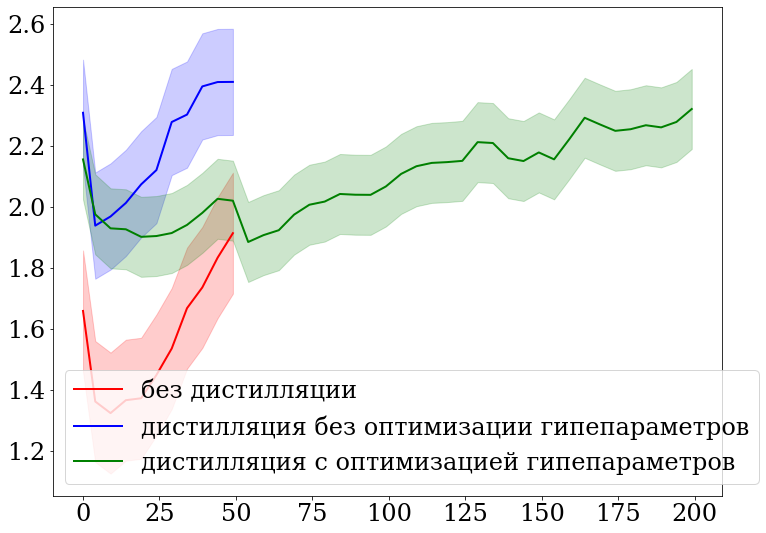

In [32]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[2]['results']))])
loss_b = np.array([data_b[2]['results'][i]['test loss'] for i in range(len(data_b[2]['results']))])
plt.plot(epoch_b, loss_b, '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b-loss_b.std(), loss_b+loss_b.std(), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([data_d[2]['results'][i]['test loss'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, loss_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, loss_d-loss_d.std(), loss_d+loss_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([data_h[2]['results'][i]['test loss'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, loss_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(epoch_h, loss_h-loss_h.std(), loss_h+loss_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('1.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

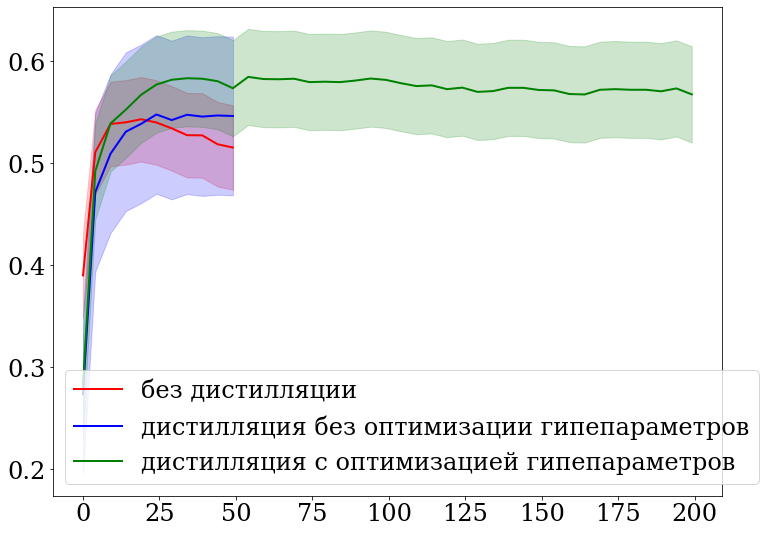

In [35]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[2]['results']))])
acc_b = np.array([data_b[2]['results'][i]['accuracy'] for i in range(len(data_b[2]['results']))])
plt.plot(epoch_b, acc_b, '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, acc_b-acc_b.std(), acc_b+acc_b.std(), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
acc_d = np.array([data_d[2]['results'][i]['accuracy'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, acc_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, acc_d-acc_d.std(), acc_d+acc_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([data_h[2]['results'][i]['accuracy'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, acc_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(epoch_h, acc_h-acc_h.std(), acc_h+acc_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('2.eps')

In [36]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
beta_d = np.array([data_d[2]['results'][i]['beta'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, beta_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, beta_d-beta_d.std(), beta_d+beta_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
beta_h = np.array([data_h[2]['results'][i]['beta'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, beta_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(epoch_h, beta_h-beta_h.std(), beta_h+beta_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('3.eps')

KeyError: 'beta'

In [37]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
temp_d = np.array([data_d[2]['results'][i]['temp'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, temp_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, temp_d-temp_d.std(), temp_d+temp_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
temp_h = np.array([data_h[2]['results'][i]['temp'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, temp_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(temp_h, temp_h-temp_h.std(), temp_h+temp_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('4.eps')

KeyError: 'temp'

In [ ]:
"""
посмотреть, куда сходятся гиперпараметры.
Задача скорее всего невыпуклая по гиперпараметрам, поэтому может быть несколько точек экстремума.

Взять одно, наилучшее значение гиперпараметров.

Посчитать дистилляцию БЕЗ оптимизации гиперпараметров с наилушчими значениями.

НЕ ЗАБУДЬ ПОМЕНЯТЬ ИМЯ ФАЙЛА ДЛЯ СОХРАНЕНИЯ
"""

In [ ]:
"""
Посчитать дистилляцию с оптимизацей гиперпараметров, в качестве начальной точки взять не случайные значения,
а start_beta, start_temp.

НЕ ЗАБУДЬ ПОМЕНЯТЬ ИМЯ ФАЙЛА ДЛЯ СОХРАНЕНИЯ
"""

In [ ]:
"""
Построить график функции потерь на тесте в зависимости от эпохи. 
На графике должны быть линии для :
    - оптимизации без дистилляции
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график точности на тесте в зависимости от эпохи. 
На графике должны быть линии для :
    - оптимизации без дистилляции
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график беты в зависимости от эпохи. 
На графике должны быть линии для :    
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график температуры в зависимости от эпохи. 
На графике должны быть линии для :    
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""